# Learning Visualisations v4: Weight visualisation during learning
This is a new attempt at visualising weight changes during learning, now that I have a better understanding of TensorFlow's auto-graph.

Focus of this notebook:
* generating heatmap images of gradients over time of learning.

Sample training domains:

---


* Deep Learning Specialization C2W2A1 experiments with weight initialisation, against a simple 2D binary classification problem.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit

## Useful tools

In [2]:
def plot_fit(history = None):
  pnum = 1

  plt.figure(layout='constrained')
  if history != None:
    plt.subplot(1,pnum,1)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
  plt.show()

class LessVerboseEpochLogger(tf.keras.callbacks.Callback):
    def __init__(self, display_interval=None, display_total=10):
        super(LessVerboseEpochLogger, self).__init__()
        self.display_interval = display_interval
        self.display_total = display_total

    def set_params(self, params):
        self.epoch_count = params['epochs']
        if self.display_interval == None:
          self.display_interval = math.floor(self.epoch_count / self.display_total)

    def on_epoch_end(self, epoch, logs=None):
        if ((epoch + 1) % self.display_interval == 0) or epoch == self.epoch_count-1:
            print(f'Epoch {epoch + 1:5d}:', end=' ')
            for key, value in logs.items():
                print(f'{key}: {value:.4f}', end='  ')
            print()

# some unit test utils
def test_equals(expected, actual):
  assert np.shape(actual) == np.shape(expected), f"Expected {expected} with shape {np.shape(expected)}, got: {actual} with shape {np.shape(actual)}"
  assert np.all(np.asarray(actual) == np.asarray(expected)), f"Expected {expected}, got: {actual}"

def test_raises(exception_type, func):
    res = None
    try:
      res = func()
    except Exception as e:
      res = e

    if isinstance(res, Exception):
      assert isinstance(res, exception_type), f"Expected {exception_type.__name__} but {type(e).__name__} was raised: {e}"
    else:
      assert False, f"Expected {exception_type.__name__} but returned without exception: {res}"

def sign_reduce(signs, axis=0):
  """
  Applies an "abs-max-like" rule against signs, for the purpose of accumulating
  signs over a sequence of data.
  Signs are assumed produced by np.sign(), which produces -1, 0, or +1.
  In a 1D sequence, the latest non-zero sign is taken as the latest.
  In a 2D sequence, the latest non-zero sign along the given axis is taken as the latest.

  Args
    signs: (n,) or (n,...) array or array-like
    axis: Axis to perform accumulation over. Default=0
  Returns
    np.array containing reduced signs
  """
  signs = np.asarray(signs)
  shape = signs.shape
  n = shape[axis]

  slice = np.take(signs, 0, axis)
  reduced = np.zeros_like(slice)
  for i in range(n):
    slice = np.take(signs, i, axis)
    reduced = np.where(slice != 0, slice, reduced)
  return reduced

# tests
test_equals(-1, sign_reduce([-1, +1, 0, -1, 0]))
test_equals(+1, sign_reduce([0, +1, -1, 0, +1]))
test_equals(+1, sign_reduce([0, +1, 0]))
test_equals(0, sign_reduce([0, 0]))

test_equals([+1, -1], sign_reduce([[-1, 0],[+1, -1]], axis=0))
test_equals([0, +1], sign_reduce([[0, 0],[0, +1]], axis=0))
test_equals([0, 0], sign_reduce([[0, 0],[0, 0]], axis=0))

test_equals([-1, -1], sign_reduce([[-1, 0],[+1, -1]], axis=1))
test_equals([0, +1], sign_reduce([[0, 0],[0, +1]], axis=1))
test_equals([0, 0], sign_reduce([[0, 0],[0, 0]], axis=1))

## Baseline: Simple model without visualisations
Actually, we're going to create a setup with few slightly different training regimes corresponding to the experiments from the coursework.


In [3]:
def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(10, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


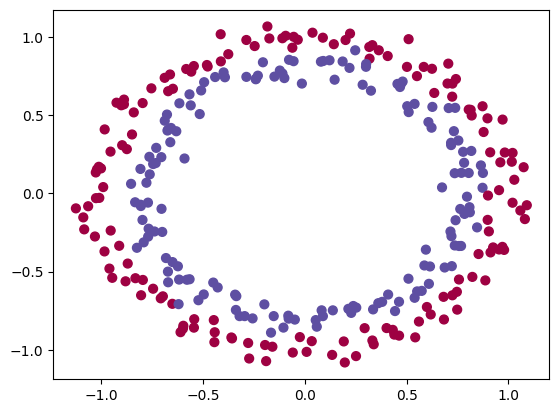

In [4]:
def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

In [ ]:
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
history = model.fit(train_X, train_Y, epochs=15000, batch_size=train_X.shape[0], verbose=0, callbacks=[LessVerboseEpochLogger()])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch  1500: loss: 0.0785  
Epoch  3000: loss: 0.0227  
Epoch  4500: loss: 0.0122  
Epoch  6000: loss: 0.0086  
Epoch  7500: loss: 0.0071  
Epoch  9000: loss: 0.0065  
Epoch 10500: loss: 0.0063  
Epoch 12000: loss: 0.0062  
Epoch 13500: loss: 0.0062  
Epoch 15000: loss: 0.0061  
Total training time: 84.01 secs


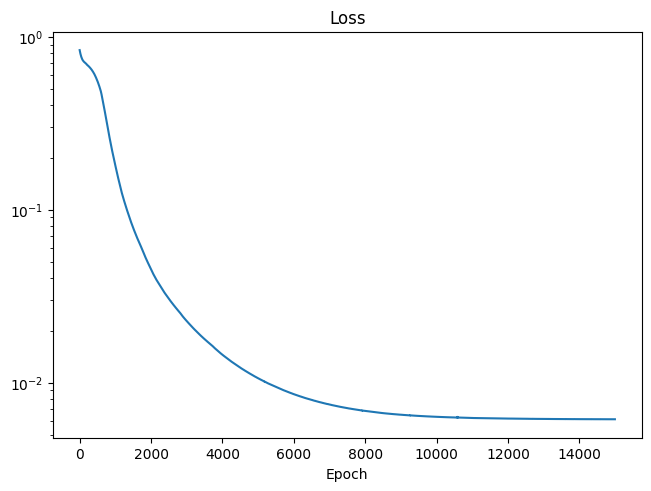

In [ ]:
plot_fit(history)

## Quick Win: Weight Histogram
Let's create quick'n'dirty function for visualising the current weights, in the form of a histogram.

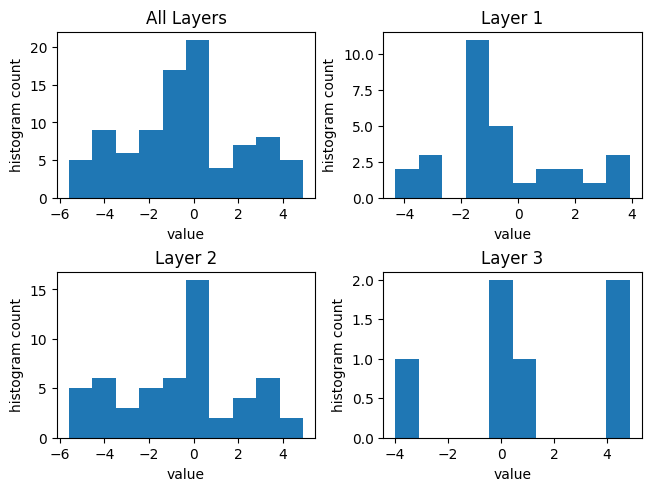

In [ ]:
def plot_weights(model):
  """
  model - the model
  """

  # collect all variables across the entire model into a single flattened array
  all_variables = []
  for layer in model.layers:
    for weight in layer.weights:
      all_variables = np.append(all_variables, weight.numpy().flatten())

  L = len(model.layers)
  plots_tot = L+1
  plots_cols = math.floor(math.sqrt(plots_tot))
  plots_rows = math.ceil(plots_tot / plots_cols)

  plt.figure(layout='constrained')

  plt.subplot(plots_rows, plots_cols, 1)
  plt.title("All Layers")
  plt.hist(all_variables)
  plt.xlabel("value")
  plt.ylabel("histogram count")

  for l in range(L):
    variables = []
    for weight in model.layers[l].weights:
      variables = np.append(variables, weight.numpy().flatten())
    plt.subplot(plots_rows, plots_cols, l+2)
    plt.title(f"Layer {l+1}")
    plt.hist(variables)
    plt.xlabel("value")
    plt.ylabel("histogram count")
  plt.show()
plot_weights(model)

## Gradient heatmap
There's two things to do here:
1. Collect gradient information during training
2. Plot it in various ways.

TensorFlow doesn't seem to provide very good means for capturing gradient information during training. It's standard Logger interface doesn't get passed that information. Instead, an Optimizer-wrapper seems the only solution.

Furthermore, while using a `tf.TensorArray` seems like a sensible option, it seems to be optimized for use _within_ a `@tf.function` and can't be initialised outside like a `tf.Variable`. So I've so found the only solution is to store everything as a matrix inside a `tf.Variable`, with rows containing a flattened copy of all the necessary information, and successive rows representing successive iterations. This particular implementation adds a bit of a delay to execution time. The problem is that it doesn't know the total number of iterations up front, so we'll get a lot of re-allocation cost. I suspect a better approach is to combine a Callback with the optimizer wrapper, because the Callback gets enough information to pre-allocate the memory.

In [ ]:
# Note the basic delegation implementation of optimizer was provided by ChatGPT and seems to be working
class LoggingOptimizerWrapper(tf.keras.optimizers.Optimizer):
  def __init__(self, optimizer='adam', name="LoggingOptimizerWrapper", **kwargs):
    """
    Args:
      delegate: real optimizer to wrap. String (name of optimizer) or optimizer instance. See `tf.keras.optimizers`.
    """
    if isinstance(optimizer, str):
      optimizer = tf.keras.optimizers.get(optimizer)
    super(LoggingOptimizerWrapper, self).__init__(f"{name}:{optimizer.name}", **kwargs)
    self._delegate = optimizer

    # the shape=None thing here tells the Variable to accept changing shapes
    # but it has the sideeffect that self._gradients_by_step.shape always returns None while executing.
    self._gradients_by_step = tf.Variable(np.zeros((0,0)), shape=tf.TensorShape(None), dtype=tf.float32)
    self._initialised = tf.Variable(0)

  def apply_gradients(self, grads_and_vars, name=None, experimental_aggregate_gradients=True):
    """
      Args:
        grads_and_vars: List of `(gradient, variable)` pairs.
    """
    grads_and_vars = list(grads_and_vars)
    grads, _ = zip(*grads_and_vars)

    # concatenate all gradient tuples into a single vector
    flattened_grads = tf.zeros(shape=(1,0))
    for grad in grads:
      flattened_grads = tf.concat([flattened_grads, tf.reshape(grad, [1, -1])], axis=1)

    # append to list (or just set list on first iteration)
    tf.cond(self._initialised < 1,
            lambda: self._gradients_by_step.assign(flattened_grads),
            lambda: self._gradients_by_step.assign(tf.concat([self._gradients_by_step, flattened_grads], axis=0)))
    self._initialised.assign(1)

    # delegate for default behaviour
    return self._delegate.apply_gradients(grads_and_vars, name, experimental_aggregate_gradients)

  # delegate all other methods and properties

  def build(self, var_list):
    super().build(var_list)

  def _create_slots(self, var_list):
    self._delegate._create_slots(var_list)

  def _create_hypers(self):
    self._delegate._create_hypers()

  def _prepare_local(self, var_device, var_dtype, apply_state):
    return self._delegate._prepare_local(var_device, var_dtype, apply_state)

  def _resource_apply_dense(self, grad, var, apply_state=None):
    return self._delegate._resource_apply_dense(grad, var, apply_state)

  def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
    return self._delegate._resource_apply_sparse(grad, var, indices, apply_state)

  def get_config(self):
    base_config = super(LoggingOptimizerWrapper, self).get_config()
    return {**base_config, "_delegate": tf.keras.optimizers.serialize(self._delegate)}

  @classmethod
  def from_config(cls, config, custom_objects=None):
    delegate_config = config.pop('_delegate')
    delegate = tf.keras.optimizers.deserialize(delegate_config, custom_objects=custom_objects)
    return cls(delegate, **config)

  def _serialize_hyperparameter(self, hyperparameter):
    return self._delegate._serialize_hyperparameter(hyperparameter)

  def get_updates(self, loss, params):
    return self._delegate.get_updates(loss, params)

  def get_weights(self):
    return self._delegate.get_weights()

  def set_weights(self, weights):
    self._delegate.set_weights(weights)

  def variables(self):
    return self._delegate.variables()

  def get_slot(self, var, name):
    return self._delegate.get_slot(var, name)

  def get_slot_names(self):
    return self._delegate.get_slot_names()

model = binary_classification_model('he_normal')
#model.compile(optimizer=LoggingOptimizerWrapper(tf.keras.optimizers.Adam()), loss='binary_crossentropy')
loggingOptimizer = LoggingOptimizerWrapper()
model.compile(optimizer=loggingOptimizer, loss='binary_crossentropy')
history = model.fit(train_X, train_Y, epochs=4, batch_size=train_X.shape[0])
gradient_history = loggingOptimizer._gradients_by_step.numpy()
print(f"gradient_history: {gradient_history.shape}")

Epoch 1/4
1/1 [==============================] - 1s 913ms/step - loss: 0.7673
Epoch 2/4
1/1 [==============================] - 0s 8ms/step - loss: 0.7656
Epoch 3/4
1/1 [==============================] - 0s 10ms/step - loss: 0.7639
Epoch 4/4
1/1 [==============================] - 0s 8ms/step - loss: 0.7623
gradient_history: (4, 91)


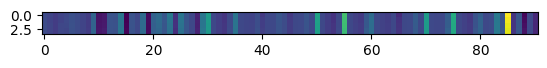

In [ ]:
plt.imshow(gradient_history)

In [ ]:
start = tf.timestamp()
model = binary_classification_model('he_normal')
loggingOptimizer = LoggingOptimizerWrapper()
model.compile(optimizer=loggingOptimizer, loss='binary_crossentropy')
history = model.fit(train_X, train_Y, epochs=5000, batch_size=train_X.shape[0], verbose=0, callbacks=[LessVerboseEpochLogger()])
duration = tf.timestamp() - start
gradient_history = loggingOptimizer._gradients_by_step.numpy()
print(f"gradient_history: {gradient_history.shape}")
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch   500: loss: 0.3958  
Epoch  1000: loss: 0.1232  
Epoch  1500: loss: 0.0669  
Epoch  2000: loss: 0.0443  
Epoch  2500: loss: 0.0339  
Epoch  3000: loss: 0.0275  
Epoch  3500: loss: 0.0230  
Epoch  4000: loss: 0.0195  
Epoch  4500: loss: 0.0167  
Epoch  5000: loss: 0.0144  
gradient_history: (5000, 91)
Total training time: 32.87 secs


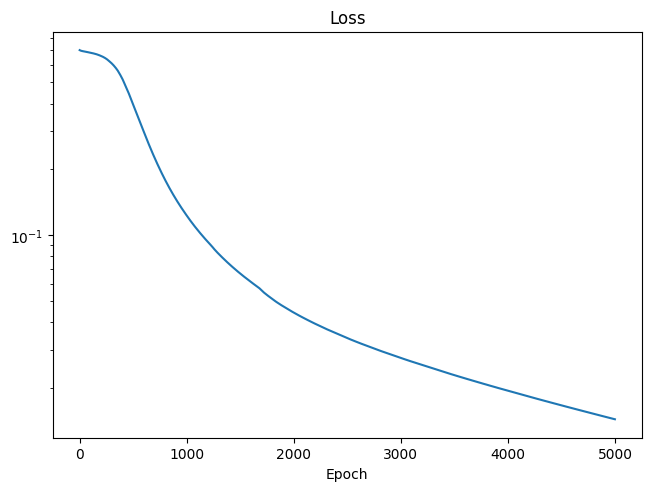

In [ ]:
plot_fit(history)

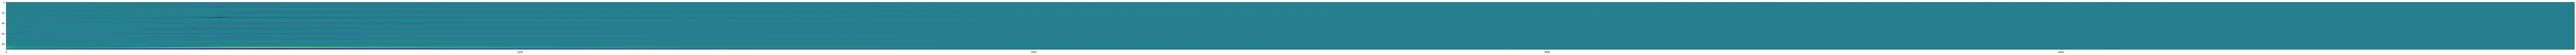

In [ ]:
 plt.figure(figsize = (200,500))
plt.imshow(gradient_history.T)

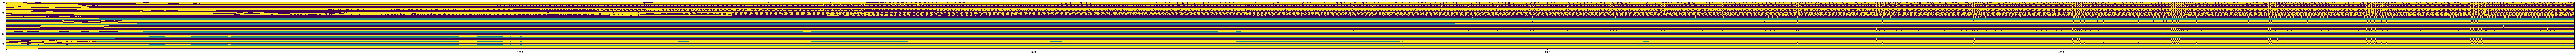

In [ ]:
plt.figure(figsize = (200,500))
plt.imshow(np.sign(gradient_history.T))

In [ ]:
gradient_history.shape

(5000, 91)

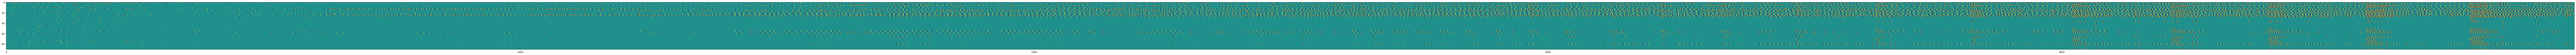

In [ ]:
plt.figure(figsize = (200,500))
plt.imshow((np.sign(gradient_history[2:5000,:]) - np.sign(gradient_history[1:4999,:])).T)

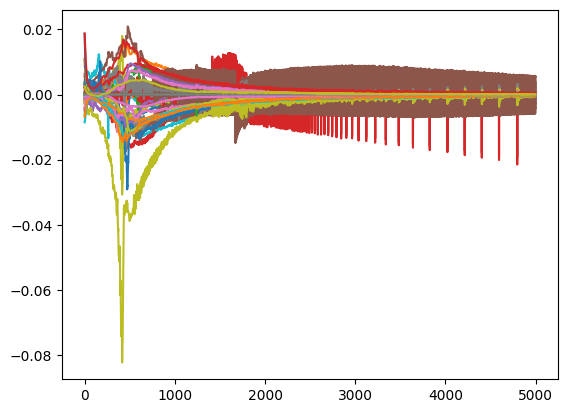

In [ ]:
plt.plot(gradient_history[:,1:50])
plt.show()

## Filtering gradient information
Turning that data into something that clearly highlights when the gradient sign is fluctuating to an extent that causes a problem isn't going to be easy.
Let's start with a couple of interesting single variables and see what we can figure out.


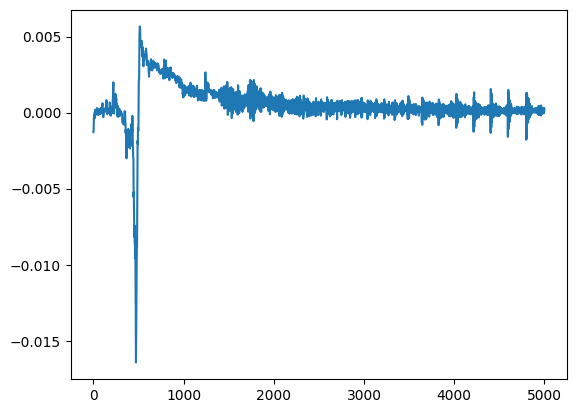

In [ ]:
plt.plot(gradient_history[:,1])
plt.show()

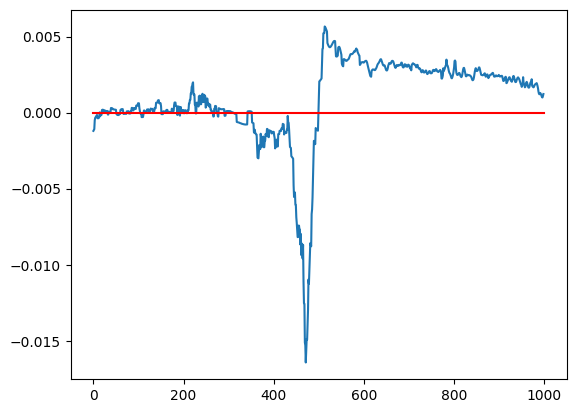

In [ ]:
dat = gradient_history[1:1000,1]
plt.plot(dat)
plt.plot([0, 1000], [0, 0], 'r-')
plt.show()

This took a bit of experimentation. The following approach seems to work quite well:
* use a range of exponential weighted moving averages to accumulate the recent trend, and then pick the avg with the highest value (of the same sign) and use that to calculate the magnitude whenever the sign changes.

Note, I'd also like to measure the variances and add about 2.5x SD to the means when identifying the magnitude of error. As that will give a more accurate measure of the magnitude of gradient oscillation. However, I haven't yet figured out the right scaling rule to calculate the variances.

In [ ]:
a = np.array([[1,2,3,4,5],[1,2,3,4,5]])
b = np.array([1,2]).reshape(2,1)
a * b

array([[ 1,  2,  3,  4,  5],
       [ 2,  4,  6,  8, 10]])

In [ ]:
def accumulate_exp_averages(dat):
  """
  dat: 1D vector or 2D tensor (t=time,f=features) with first dimension reflecting time in some way (eg: iterations, epochs)
  Returns:
    tuple (means, variances), with each item having shape (t,f,b), where b = number of betas
  """

  # WARNING
  # The variances calculation isn't working yet. The problem is that they
  # get scaled to very small values (circa 1x10-6).
  # For high-frequency moving average (small betas), the mean is already
  # very close to the current value, so the diff is small.
  # For low-frequnecy moving average (betas ~= 1), the averaging
  # effect reduces the scale of the error.
  # Apart from the scale problem, the values are actually quite
  # representative of what I want to capture.
  # So I just need to figure out a reliable scaling rule.

  # Identify a range of betas that provide a power-of-2 sampling
  # of different equivalent window sizes, up to 1/5-th of the total length
  # of the data
  # rule: 1/(1-beta) ~= width of equivalent sliding window
  # =>    beta = 1 - 1/w
  max_window_base = math.floor(math.log2(dat.shape[0]/5))
  window_size_bases = np.arange(1, max_window_base+1);
  window_sizes = 2**window_size_bases
  betas = 1 - 1/window_sizes
  print(f"window_sizes: {window_sizes}")
  print(f"betas: {betas}")

  # if dat is a 1D vector, then turn into 2D
  dat = dat.reshape((dat.shape[0], -1))

  n  = dat.shape[0] # number of time steps
  fs = dat.shape[1] # number of input features
  bs = len(betas)   # number of output features

  # calculate exponential weighted moving means and variances
  out_means = []
  out_variances = []

  means = np.ones(shape=(fs, bs)) * dat[0,:].reshape((fs, 1))
  variances = np.zeros(shape=(fs, bs))
  assert means.shape == (fs, bs)
  assert variances.shape == (fs, bs)

  for i, x in enumerate(dat):
    assert x.shape == (fs,)
    x = x.reshape(fs, 1)

    means = betas * means + (1-betas) * x
    assert means.shape == (fs, bs)

    variance = (means - x)**2
    assert variance.shape == (fs, bs)

    variances = betas * variances + (1-betas) * variance
    out_means.append(means)
    out_variances.append(variances)

  a = np.array(out_means)
  b = np.array(out_variances)
  assert a.shape == (n, fs, bs)
  assert b.shape == (n, fs, bs)
  return a, b

#means,variances = accumulate_exp_averages(dat)
means,variances = accumulate_exp_averages(gradient_history[1:1000,0:2])
means.shape

window_sizes: [  2   4   8  16  32  64 128]
betas: [0.5       0.75      0.875     0.9375    0.96875   0.984375  0.9921875]


(999, 2, 7)

window_sizes: [  2   4   8  16  32  64 128]
betas: [0.5       0.75      0.875     0.9375    0.96875   0.984375  0.9921875]
means: (999, 5, 7)


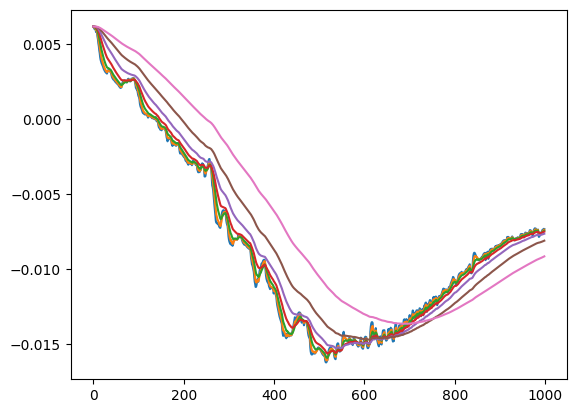

In [ ]:
means,variances = accumulate_exp_averages(gradient_history[1:1000,0:5])
print(f"means: {means.shape}")
#plt.plot(dat)
plt.plot(means[:,4,:])
#plt.plot(variances.reshape((dat.shape[0], -1)))
plt.show()

window_sizes: [  2   4   8  16  32  64 128]
betas: [0.5       0.75      0.875     0.9375    0.96875   0.984375  0.9921875]


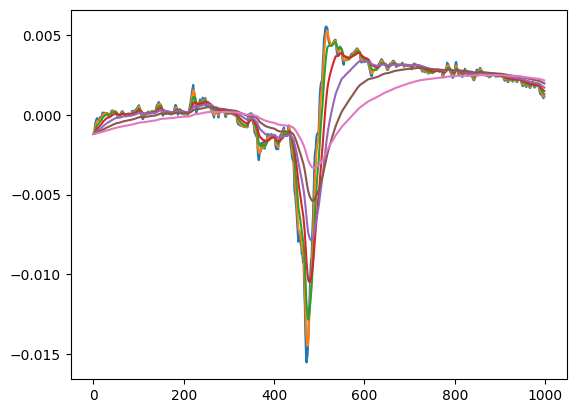

In [ ]:
means,variances = accumulate_exp_averages(dat)
#plt.plot(dat)
plt.plot(means.reshape((dat.shape[0], -1)))
#plt.plot(variances.reshape((dat.shape[0], -1)))
plt.show()

In [ ]:
def sign_change_magnitudes_smooth(dat):
  """
  dat: 1D vector or 2D tensor (t=time,f=features) with first dimension reflecting time in some way (eg: iterations, epochs)
  Returns:
    np.array (t,f) with each value indicating the magnitude of sign change
  """
  means, _ = accumulate_exp_averages(dat)

  # if dat is a 1D vector, then turn into 2D
  dat = dat.reshape((dat.shape[0], -1))

  n  = dat.shape[0] # number of time steps
  fs = dat.shape[1] # number of input features
  bs = means.shape[2] # number of betas

  assert means.shape == (n, fs, bs), means.shape

  out = []
  prev = dat[0,:]
  for i, x in enumerate(dat):
    assert x.shape == (fs,), x.shape

    select = np.sign(x) != np.sign(prev)
    assert select.shape == (fs,), select.shape

    maxs = np.max(means[i], axis=1)
    mins = np.min(means[i], axis=1)
    assert maxs.shape == (fs,), maxs.shape
    assert mins.shape == (fs,), mins.shape

    abs_max = np.max([np.abs(maxs), np.abs(mins)], axis=0)
    assert abs_max.shape == (fs,), abs_max.shape

    #print(x[select and x == 0].shape)
    #print(abs_max[select and x == 0].shape)

    mag = np.zeros_like(x)
    mag[select * x == 0] = abs_max[select * x == 0]
    mag[select * x > 0] = maxs[select * x > 0]
    mag[select * x < 0] = mins[select * x < 0]
    out.append(mag)
    prev = x

  return np.array(out)

events = sign_change_magnitudes_smooth(dat)

window_sizes: [  2   4   8  16  32  64 128]
betas: [0.5       0.75      0.875     0.9375    0.96875   0.984375  0.9921875]


window_sizes: [  2   4   8  16  32  64 128]
betas: [0.5       0.75      0.875     0.9375    0.96875   0.984375  0.9921875]
window_sizes: [  2   4   8  16  32  64 128]
betas: [0.5       0.75      0.875     0.9375    0.96875   0.984375  0.9921875]


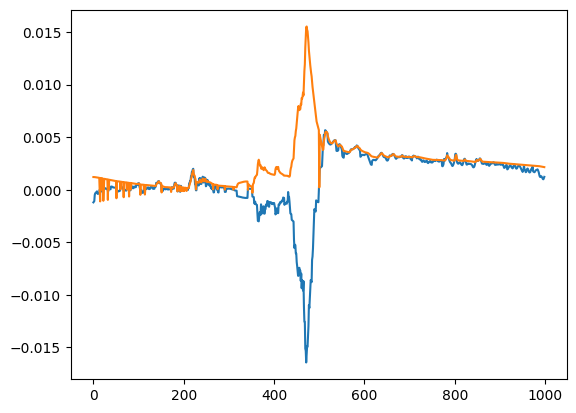

In [ ]:
avgs = accumulate_exp_averages(dat)
events = sign_change_magnitudes_smooth(dat)
plt.plot(dat)
#plt.plot(avgs)
plt.plot(events)
plt.show()

In [ ]:
a = np.array([[1,2,3,4], [1,2,3,4]])
b = -a
a[np.all(a % 2 ==0, a > 2)]# = b[a % 2 ==0 and a > 2]
#a

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
a[(a % 2 == 0) * (a > 2)]

In [ ]:
dat2 = gradient_history[:,0:5]
avgs = accumulate_exp_averages(dat2)
events = sign_change_magnitudes_smooth(dat2)
plt.plot(dat2)
#plt.plot(avgs)
plt.plot(events)
plt.show()

**CHANGE OF TACK: I'm discarding what I've done above so far. I'll keep the results that for reference and explanation, but I'm off to try something different**

## A new Approach
The above is is still not quite what we want. At best the magnitude recorded here is 1/2 of what we actually want. Because we really want to know the _total magnitude of oscillation_. That requires measuring peak-to-peak, and furthermore preferentially only identifying events at those peaks, but identifying peaks is extremely difficult in noisy data.

In [ ]:
a = np.array([[1,3,4], [5,6,7]])
np.take(a, [0,1], axis=0)

In [ ]:
# TODO rename to 'discrete' and 'smooth'
def sign_change_magnitudes_events(dat, **kwargs):
  """
  Arguments:
    dat: 1D vector or 2D tensor (t=time,f=features) with first dimension reflecting time in some way (eg: iterations, epochs)

  Keyword arguments:
    filtering: 'distinct' or 'smooth'
      distinct: Produces a single event at the point of sign change, with the value equal to the difference between adjacent peaks.
        This reflects the most accurate measure of sign changes, and is most useful when looking at individuals values.
        However, it is less useful when aggregating across multiple variables, but the events are likely to occur at slightly different
        times, and so you loose the general trend amongst the noise.
      smooth: Applies smoothing in the form of memory-with-exponential-decay to the events starting at each point of sign change.
        This is most useful when looking at the aggregate (eg: sum or mean) across multiple variables. The smoothing spreads out the discrete
        events so that they overlap.
    beta: exponential weighting used when smoothing. Default: adaptively chooses a value that approximates 1/10th the length of the data (first axis)
  Returns:
    np.array (t,f) with each point of sign change holding the the peak-to-peak (signed) magnitude of sign change
  """

  # kwargs
  filtering = kwargs.get('filtering', 'distinct')
  beta = kwargs.get('beta', None)

  # if dat is a 1D vector, then turn into 2D
  dat = dat.reshape((dat.shape[0], -1))

  n  = dat.shape[0] # number of time steps
  fs = dat.shape[1] # number of input features

  # defaulting
  if beta == None:
      window_size_base = math.floor(math.log2(dat.shape[0]/10))
      window_size = 2**window_size_base
      beta = 1 - 1/window_size

  # all "accum_..." are interpreted as tracking up-to-but-excluding the current x
  # (also note that due to the way that we manipulate these, a single instance is
  #  used throughout as a variable that changes over time)
  # ..0 = current block
  # ..1 = previous block
  accum_sign0 = np.zeros_like(dat[0,:])
  accum_peak0 = np.zeros_like(dat[0,:])
  accum_peak_point0 = np.zeros_like(dat[0,:], dtype=int)
  accum_change_point0 = np.zeros_like(dat[0,:], dtype=int)
  accum_peak1 = np.zeros_like(dat[0,:])

  # pre-allocate for reuse when gathering from
  zeros = np.zeros_like(dat[0,:])

  out = []
  for i, x in enumerate(dat):
    assert x.shape == (fs,), x.shape

    # identify sign flips
    sign = sign_reduce([accum_sign0, np.sign(x)], axis=0)  # sorts out the zeros, so almost always only +1 or -1
    flips = (accum_sign0 * sign) < 0           # only flips once x becomes +1 or -1, not when it just touches 0
    assert sign.shape == (fs,), sign.shape
    assert flips.shape == (fs,), flips.shape
    assert np.all(np.sign(x)[flips] != 0)

    # rotate blocks on sign flips
    accum_peak1[flips] = accum_peak0[flips]

    # start new block on sign flips
    assert accum_sign0.shape == (fs,), accum_sign0.shape
    assert sign.shape == (fs,), sign.shape
    assert accum_sign0[flips].shape == sign[flips].shape, accum_sign0[flips].shape
    accum_sign0[flips] = sign[flips]
    accum_peak0[flips] = zeros[flips]
    accum_change_point0[flips] = i

    # accumulate against current block
    accum_sign0 = sign
    accum_peak0[sign >= 0] = np.max([accum_peak0, x], axis=0)[sign >= 0]
    accum_peak0[sign < 0]  = np.min([accum_peak0, x], axis=0)[sign < 0]
    assert accum_sign0.shape == (fs,), accum_sign0.shape
    assert accum_peak0.shape == (fs,), accum_peak0.shape

    # track magnitudes but store against change points
    out.append(np.zeros_like(x))
    mag = accum_peak0 - accum_peak1 # signed magnitude of change
    for j, i2 in enumerate(accum_change_point0):
      assert np.shape(out[i2][j]) == (), np.shape(out[i2][j])
      assert np.shape(mag[j]) == (), np.shape(mag[j])
      out[i2][j] = mag[j]

  # apply filtering to results
  if filtering == 'distinct':
    return np.array(out)
  else:
    out = np.array(out)
    accum = out[0]
    for i, row in enumerate(out):
      accum = beta*accum + (1-beta)*row
      accum[row != 0] = row[row != 0]
      out[i] = accum
    return np.array(out)

In [ ]:
dat2 = gradient_history[:,0:2]
events = sign_change_magnitudes_events(dat2)
print(f"dat2: {dat2.shape}, events: {events.shape}")

dat2: (5000, 2), events: (5000, 2)


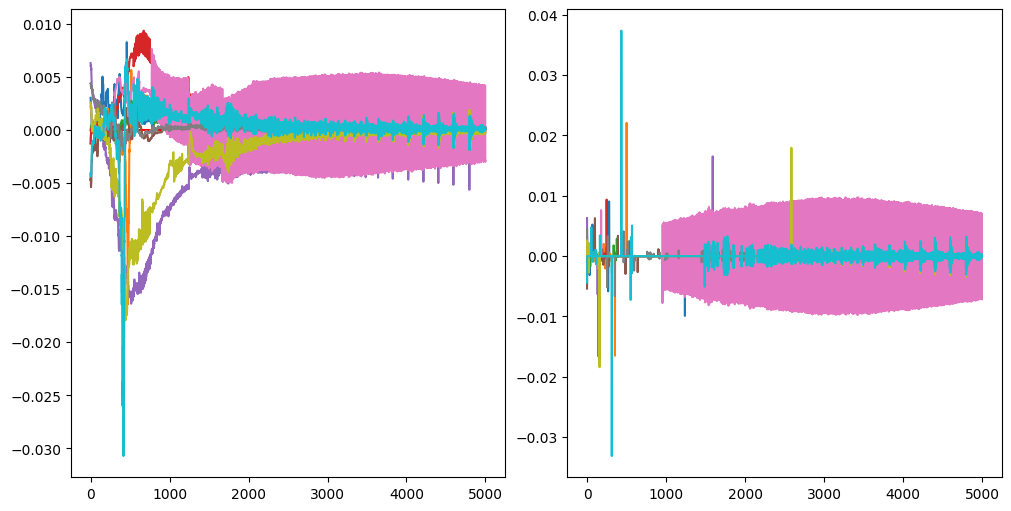

In [ ]:
dat2 = gradient_history[:,0:10]
events = sign_change_magnitudes_events(dat2)

plt.figure(figsize=(10,5), layout='constrained')
plt.subplot(1,2,1)
plt.plot([0, dat2.shape[0]], [0, 0], 'r-')
plt.plot(dat2)
plt.subplot(1,2,2)
plt.plot(events)


plt.show()

In [ ]:
events = sign_change_magnitudes_events(gradient_history)

In [ ]:
events.shape

(5000, 91)

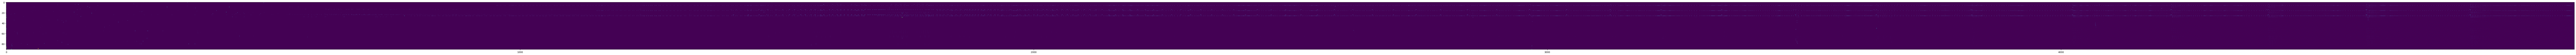

In [ ]:
plt.figure(figsize = (200,500))
plt.imshow(np.abs(events.T))

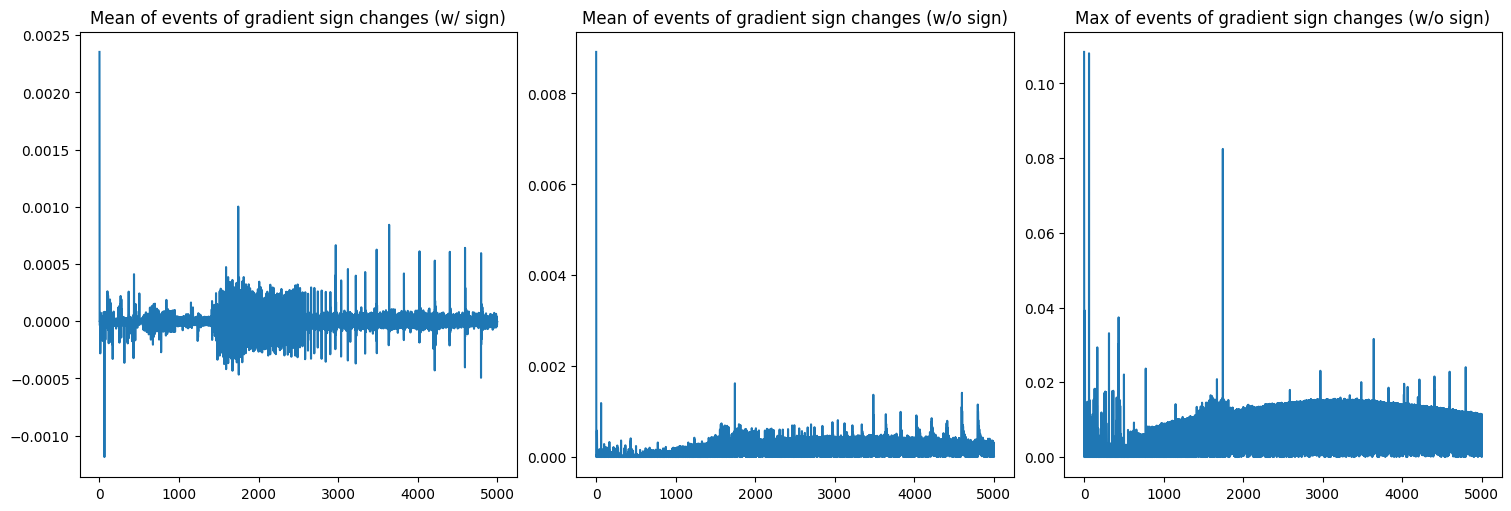

In [ ]:
plt.figure(figsize = (15,5), layout='constrained')
plt.subplot(1,3,1)
plt.plot(np.mean(events, axis=1))
plt.title('Mean of events of gradient sign changes (w/ sign)')
plt.subplot(1,3,2)
plt.plot(np.mean(np.abs(events), axis=1))
plt.title('Mean of events of gradient sign changes (w/o sign)')
plt.subplot(1,3,3)
plt.plot(np.max(np.abs(events), axis=1))
plt.title('Max of events of gradient sign changes (w/o sign)')
plt.show()

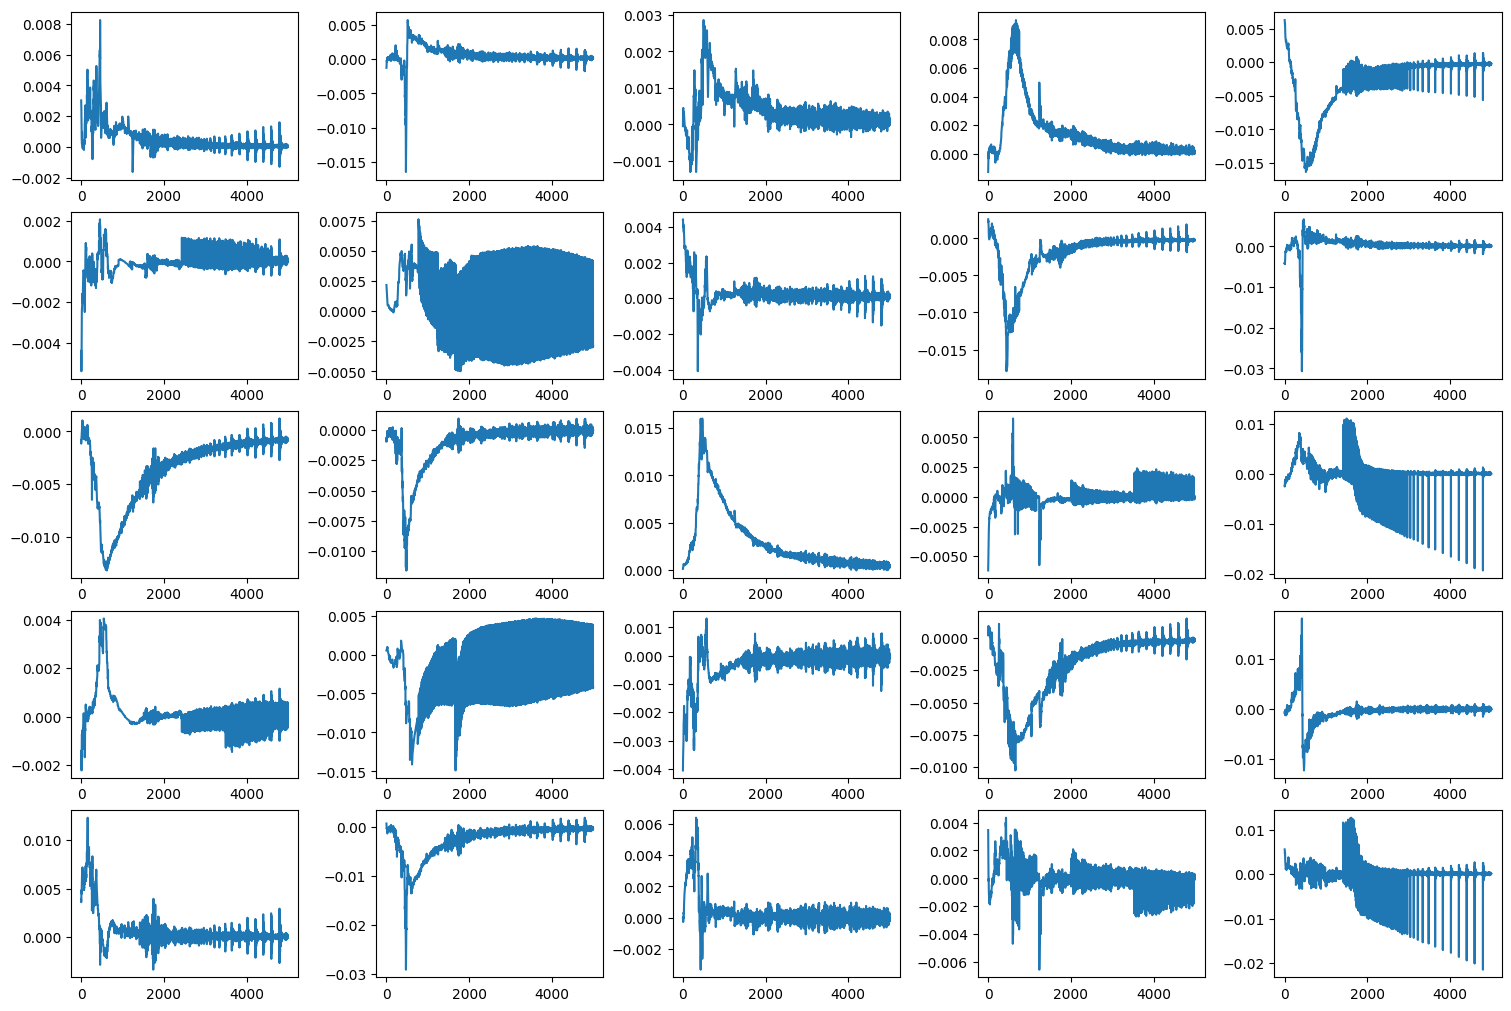

In [ ]:
plt.figure(figsize = (15,10), layout='constrained')
for k in range(25):
  plt.subplot(5,5,k+1)
  plt.plot(gradient_history[:,k])
plt.show()

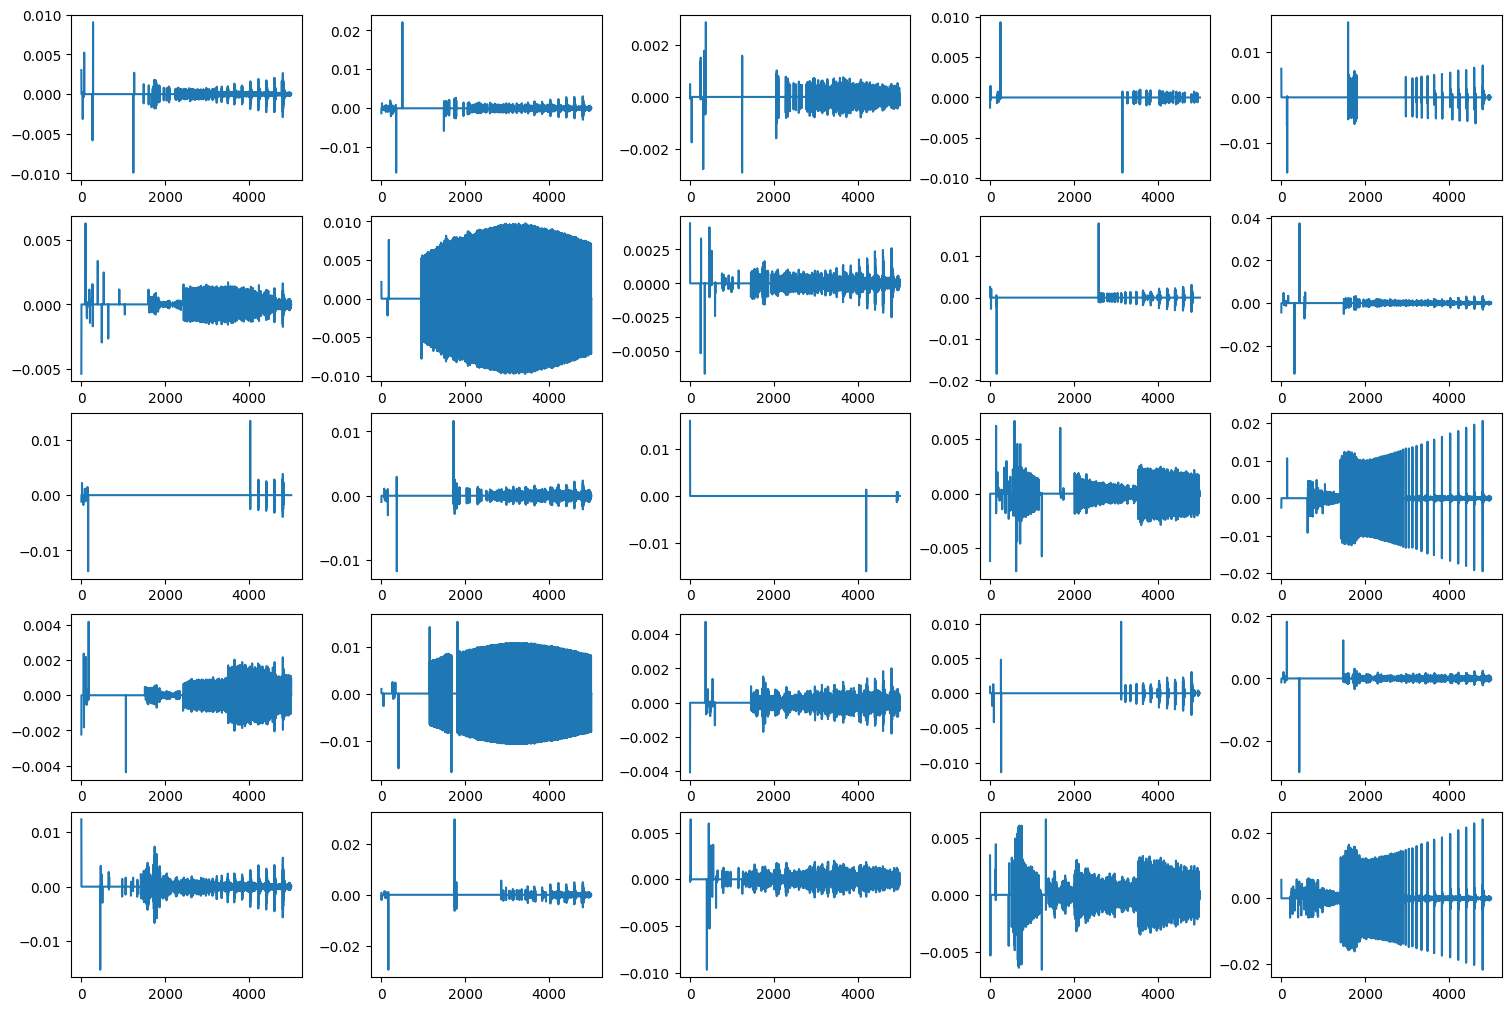

In [ ]:
plt.figure(figsize = (15,10), layout='constrained')
for k in range(25):
  plt.subplot(5,5,k+1)
  plt.plot(events[:,k])
plt.show()

In [ ]:
# smoothed
events = sign_change_magnitudes_events(gradient_history, filtering='smooth')

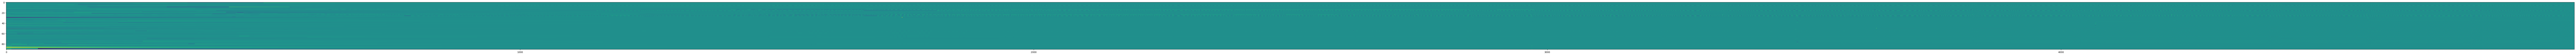

In [ ]:
plt.figure(figsize = (200,500))
plt.imshow(events.T)

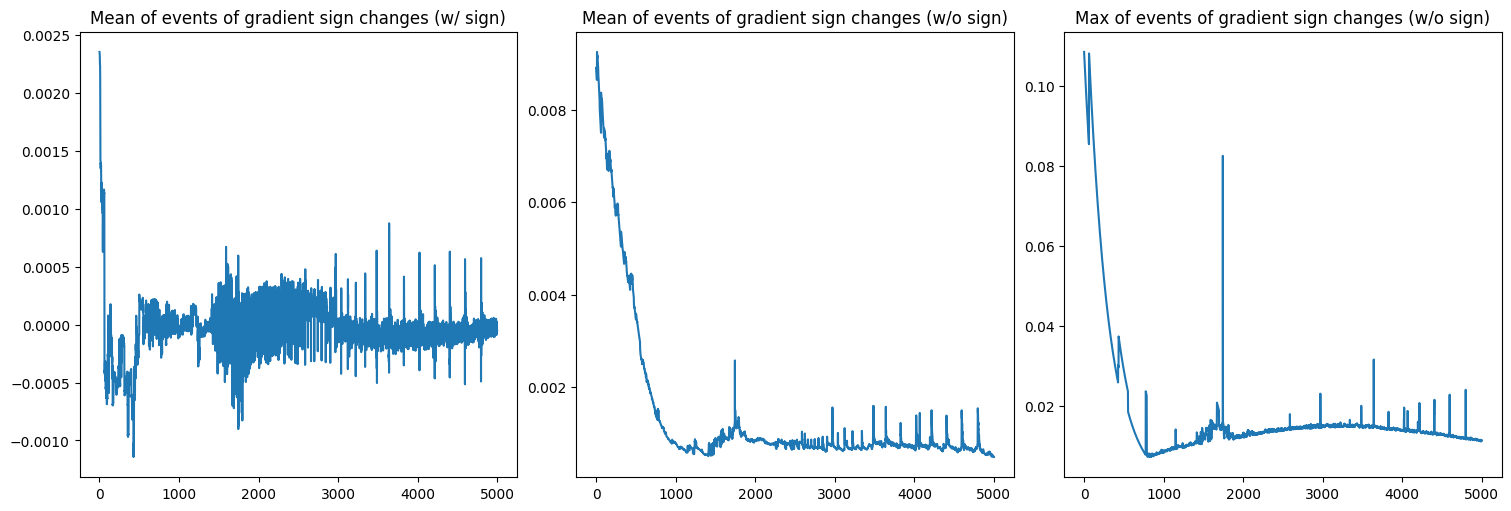

In [ ]:
plt.figure(figsize = (15,5), layout='constrained')
plt.subplot(1,3,1)
plt.plot(np.mean(events, axis=1))
plt.title('Mean of events of gradient sign changes (w/ sign)')
plt.subplot(1,3,2)
plt.plot(np.mean(np.abs(events), axis=1))
plt.title('Mean of events of gradient sign changes (w/o sign)')
plt.subplot(1,3,3)
plt.plot(np.max(np.abs(events), axis=1))
plt.title('Max of events of gradient sign changes (w/o sign)')
plt.show()

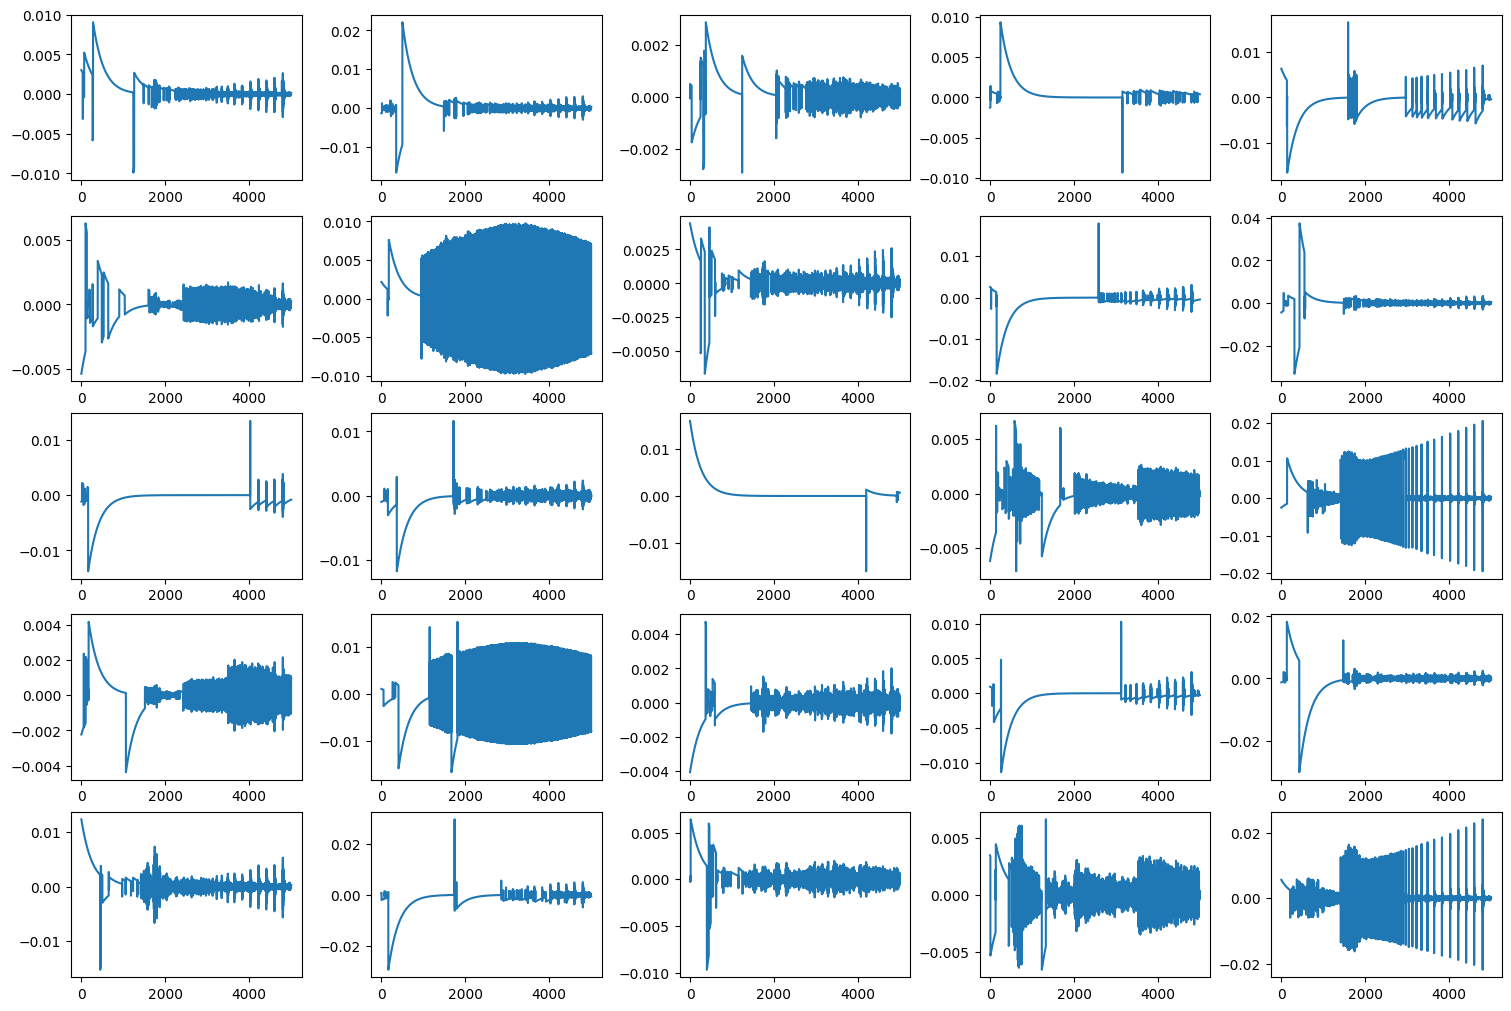

In [ ]:
plt.figure(figsize = (15,10), layout='constrained')
for k in range(25):
  plt.subplot(5,5,k+1)
  plt.plot(events[:,k])
plt.show()

## More Experiments
Great. This is working. Let's run some experiments.
Firstly, we'll use the current model against its full training duration (15,000 instead of 5,000), and then experiment with different learning rates.

In [ ]:
start = tf.timestamp()
model = binary_classification_model('he_normal')
loggingOptimizer = LoggingOptimizerWrapper()
model.compile(optimizer=loggingOptimizer, loss='binary_crossentropy')
history = model.fit(train_X, train_Y, epochs=15000, batch_size=train_X.shape[0], verbose=0, callbacks=[LessVerboseEpochLogger()])
duration = tf.timestamp() - start
gradient_history = loggingOptimizer._gradients_by_step.numpy()
print(f"gradient_history: {gradient_history.shape}")
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch  1500: loss: 0.0967  
Epoch  3000: loss: 0.0305  
Epoch  4500: loss: 0.0172  
Epoch  6000: loss: 0.0107  
Epoch  7500: loss: 0.0083  
Epoch  9000: loss: 0.0076  
Epoch 10500: loss: 0.0073  
Epoch 12000: loss: 0.0071  
Epoch 13500: loss: 0.0071  
Epoch 15000: loss: 0.0070  
gradient_history: (15000, 91)
Total training time: 81.78 secs


In [ ]:
gradient_events_smooth = sign_change_magnitudes_events(gradient_history, filtering='smooth')
gradient_events_discrete = sign_change_magnitudes_events(gradient_history, filtering='distinct')
print(f"gradient_events: {gradient_events_smooth.shape}")

gradient_events: (15000, 91)


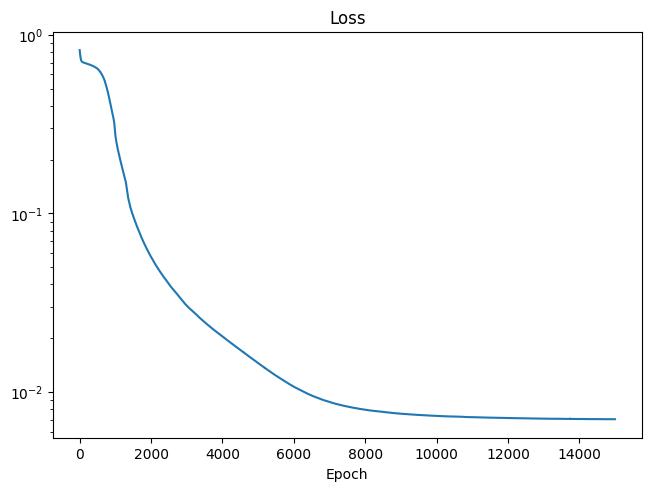

In [ ]:
plot_fit(history)

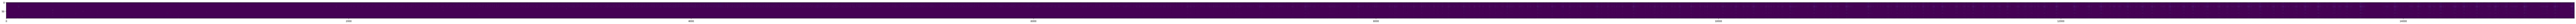

In [ ]:
plt.figure(figsize = (200,500))
plt.imshow(np.abs(gradient_events_discrete.T))
plt.show()

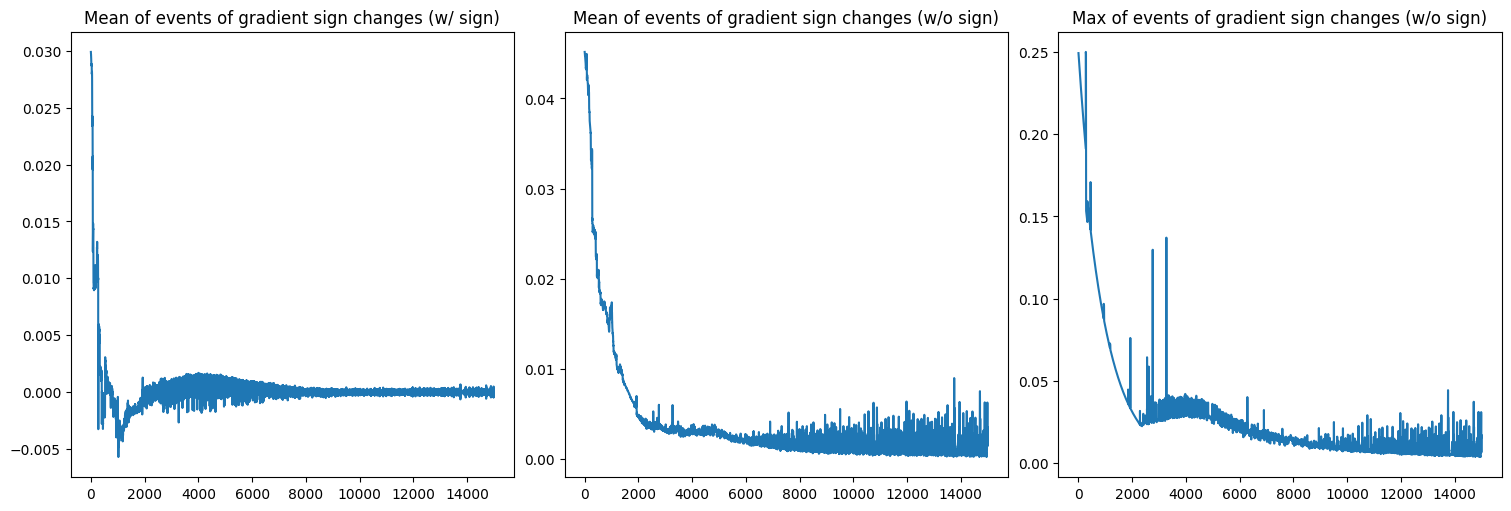

In [ ]:
plt.figure(figsize = (15,5), layout='constrained')
plt.subplot(1,3,1)
plt.plot(np.mean(gradient_events_smooth, axis=1))
plt.title('Mean of events of gradient sign changes (w/ sign)')
plt.subplot(1,3,2)
plt.plot(np.mean(np.abs(gradient_events_smooth), axis=1))
plt.title('Mean of events of gradient sign changes (w/o sign)')
plt.subplot(1,3,3)
plt.plot(np.max(np.abs(gradient_events_smooth), axis=1))
plt.title('Max of events of gradient sign changes (w/o sign)')
plt.show()

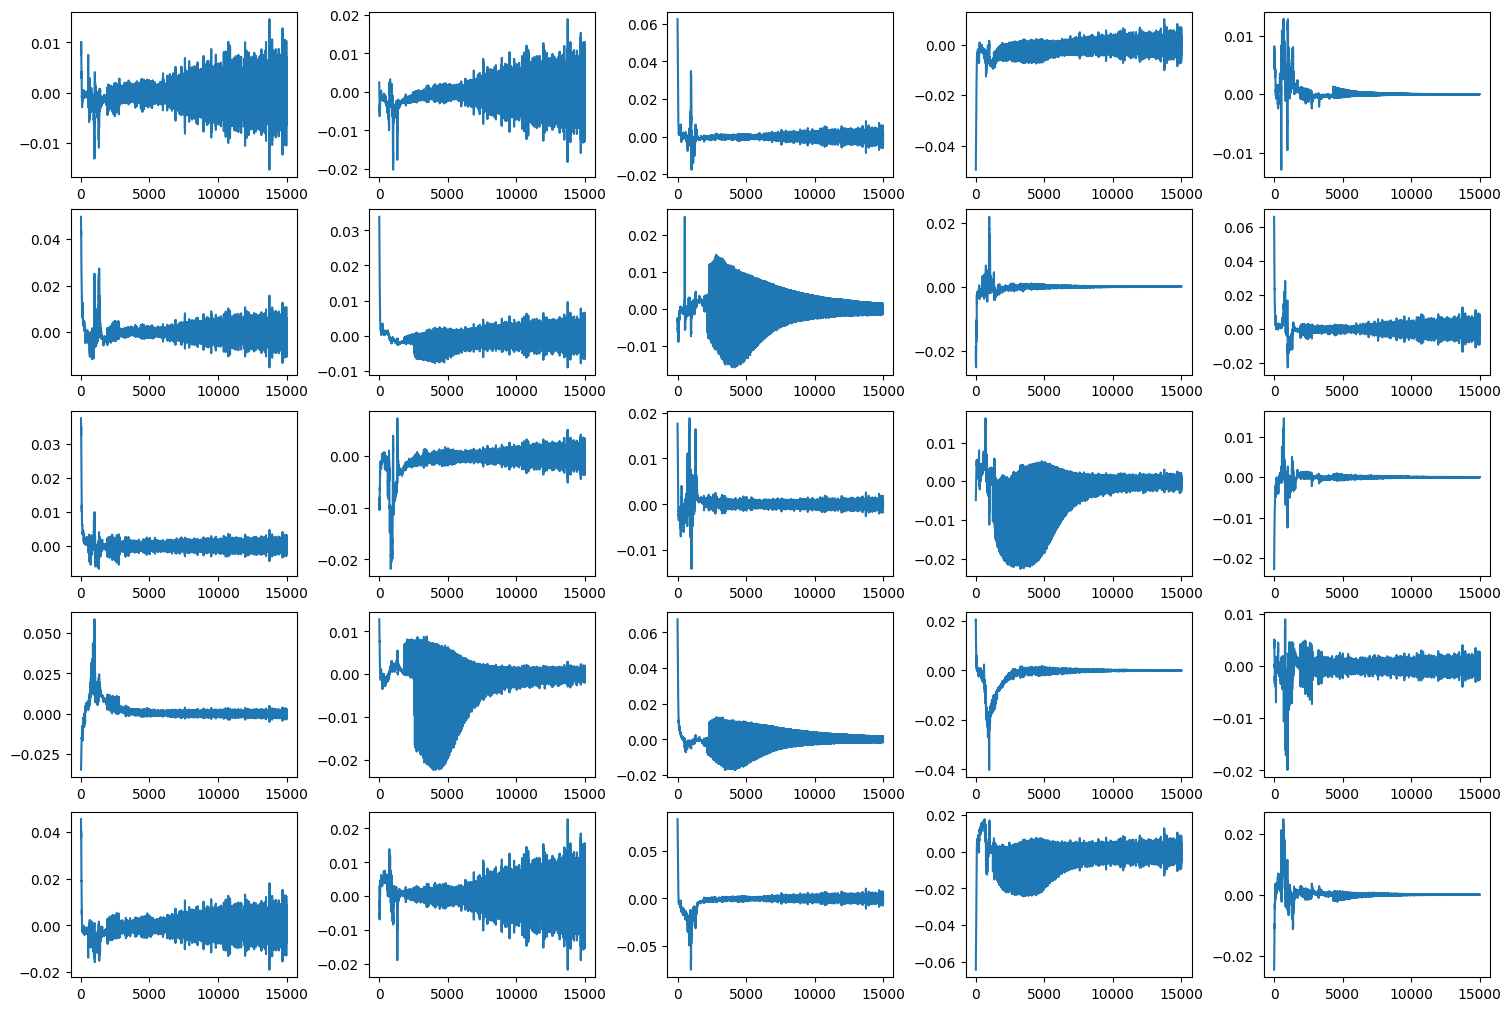

In [ ]:
plt.figure(figsize = (15,10), layout='constrained')
for k in range(25):
  plt.subplot(5,5,k+1)
  plt.plot(gradient_history[:,k])
plt.show()

Now with learning rate too high.

In [ ]:
start = tf.timestamp()
model = binary_classification_model('he_normal')
loggingOptimizer = LoggingOptimizerWrapper(tf.keras.optimizers.Adam(learning_rate=0.1))
model.compile(optimizer=loggingOptimizer, loss='binary_crossentropy')
history = model.fit(train_X, train_Y, epochs=5000, batch_size=train_X.shape[0], verbose=0, callbacks=[LessVerboseEpochLogger()])
duration = tf.timestamp() - start
gradient_history = loggingOptimizer._gradients_by_step.numpy()
print(f"gradient_history: {gradient_history.shape}")
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch   500: loss: 0.0109  
Epoch  1000: loss: 0.0079  
Epoch  1500: loss: 0.0731  
Epoch  2000: loss: 0.0093  
Epoch  2500: loss: 0.0077  
Epoch  3000: loss: 0.0070  
Epoch  3500: loss: 0.0066  
Epoch  4000: loss: 0.0084  
Epoch  4500: loss: 0.0067  
Epoch  5000: loss: 0.0078  
gradient_history: (5000, 91)
Total training time: 21.12 secs


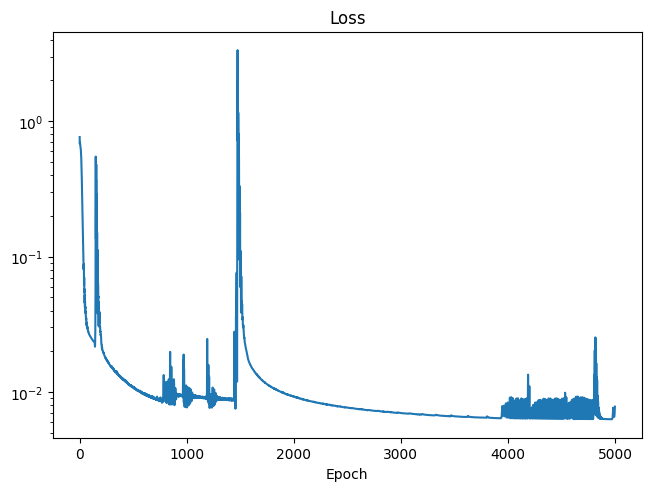

In [ ]:
plot_fit(history)

In [ ]:
gradient_events_smooth = sign_change_magnitudes_events(gradient_history, filtering='smooth')
gradient_events_discrete = sign_change_magnitudes_events(gradient_history, filtering='distinct')
print(f"gradient_events: {gradient_events_smooth.shape}")

gradient_events: (5000, 91)


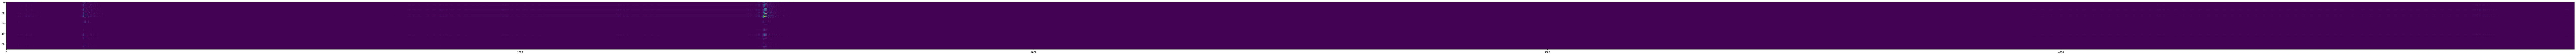

In [ ]:
plt.figure(figsize = (200,500))
plt.imshow(np.abs(gradient_events_discrete.T))
plt.show()

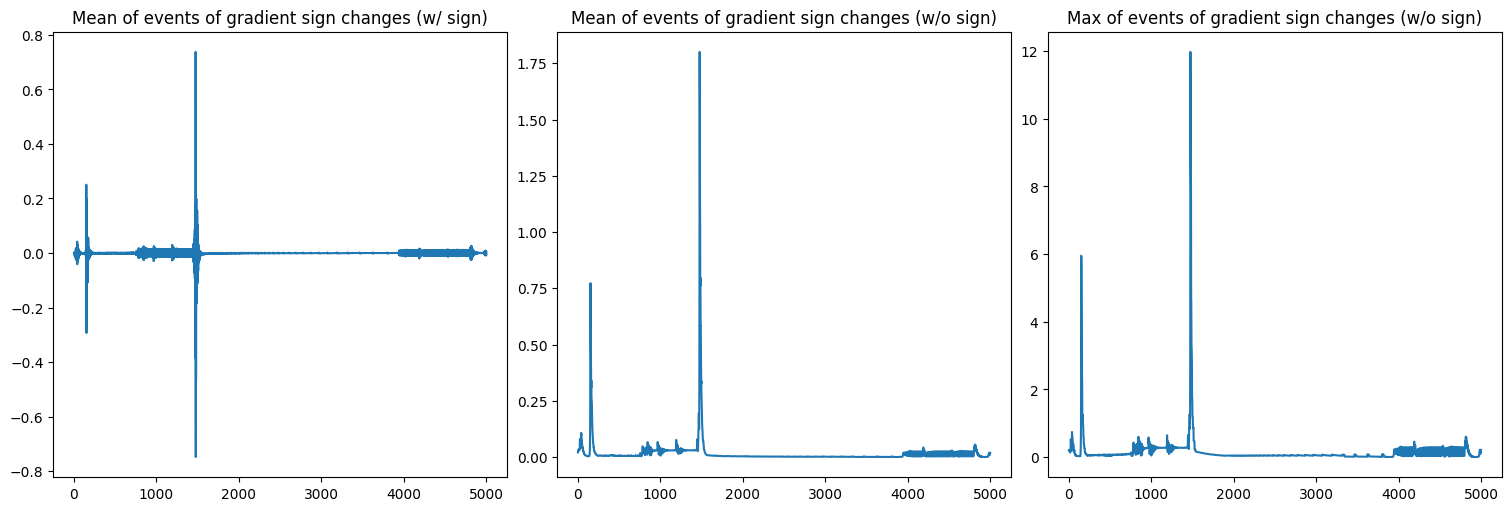

In [ ]:
plt.figure(figsize = (15,5), layout='constrained')
plt.subplot(1,3,1)
plt.plot(np.mean(gradient_events_smooth, axis=1))
plt.title('Mean of events of gradient sign changes (w/ sign)')
plt.subplot(1,3,2)
plt.plot(np.mean(np.abs(gradient_events_smooth), axis=1))
plt.title('Mean of events of gradient sign changes (w/o sign)')
plt.subplot(1,3,3)
plt.plot(np.max(np.abs(gradient_events_smooth), axis=1))
plt.title('Max of events of gradient sign changes (w/o sign)')
plt.show()

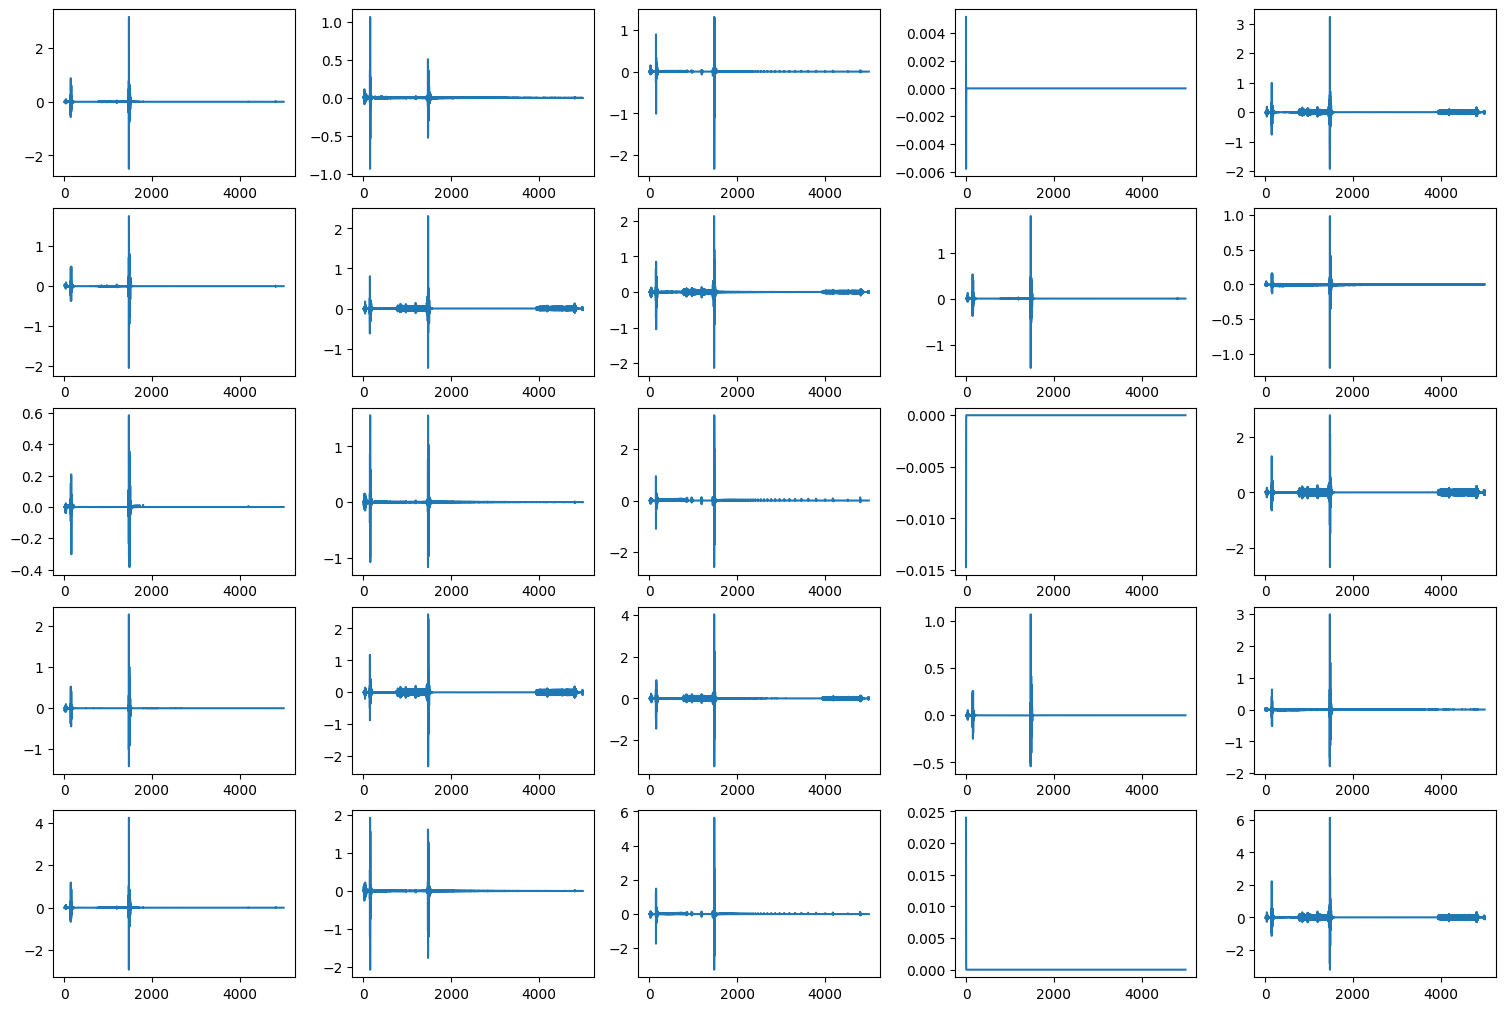

In [ ]:
plt.figure(figsize = (15,10), layout='constrained')
for k in range(25):
  plt.subplot(5,5,k+1)
  plt.plot(gradient_history[:,k])
plt.show()

Now with learning rate very low

Epoch  1500: loss: 0.7414  
Epoch  3000: loss: 0.7180  
Epoch  4500: loss: 0.7011  
Epoch  6000: loss: 0.6894  
Epoch  7500: loss: 0.6814  
Epoch  9000: loss: 0.6762  
Epoch 10500: loss: 0.6721  
Epoch 12000: loss: 0.6681  
Epoch 13500: loss: 0.6641  
Epoch 15000: loss: 0.6598  
gradient_history: (15000, 91)
Total training time: 71.89 secs


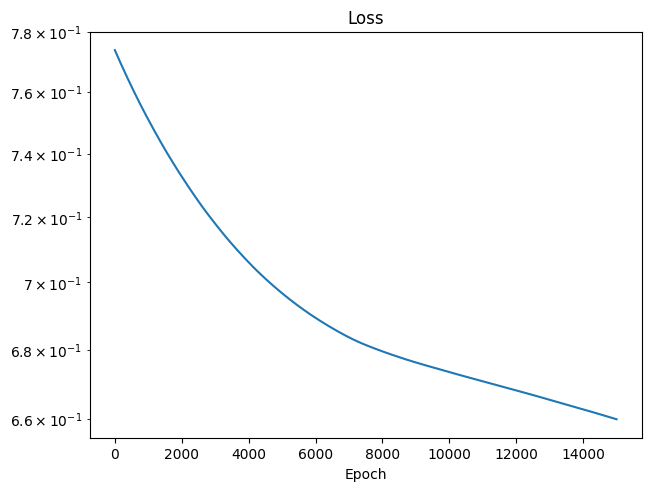

In [ ]:
start = tf.timestamp()
model = binary_classification_model('he_normal')
loggingOptimizer = LoggingOptimizerWrapper(tf.keras.optimizers.Adam(learning_rate=0.00001))
model.compile(optimizer=loggingOptimizer, loss='binary_crossentropy')
history = model.fit(train_X, train_Y, epochs=15000, batch_size=train_X.shape[0], verbose=0, callbacks=[LessVerboseEpochLogger()])
duration = tf.timestamp() - start
gradient_history = loggingOptimizer._gradients_by_step.numpy()
print(f"gradient_history: {gradient_history.shape}")
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)

In [ ]:
gradient_events_smooth = sign_change_magnitudes_events(gradient_history, filtering='smooth')
gradient_events_discrete = sign_change_magnitudes_events(gradient_history, filtering='distinct')
print(f"gradient_events: {gradient_events_smooth.shape}")

gradient_events: (15000, 91)


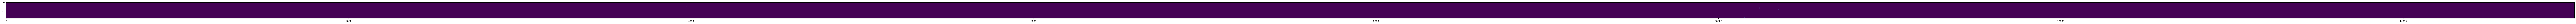

In [ ]:
plt.figure(figsize = (200,500))
plt.imshow(np.abs(gradient_events_discrete.T))
plt.show()

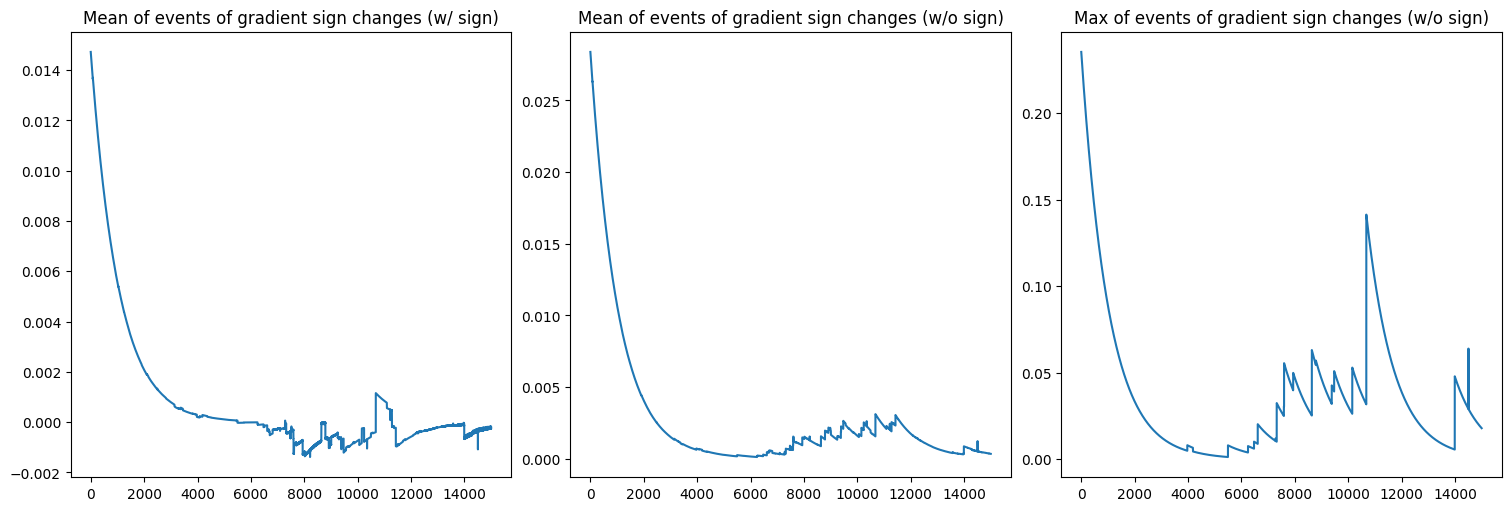

In [ ]:
plt.figure(figsize = (15,5), layout='constrained')
plt.subplot(1,3,1)
plt.plot(np.mean(gradient_events_smooth, axis=1))
plt.title('Mean of events of gradient sign changes (w/ sign)')
plt.subplot(1,3,2)
plt.plot(np.mean(np.abs(gradient_events_smooth), axis=1))
plt.title('Mean of events of gradient sign changes (w/o sign)')
plt.subplot(1,3,3)
plt.plot(np.max(np.abs(gradient_events_smooth), axis=1))
plt.title('Max of events of gradient sign changes (w/o sign)')
plt.show()

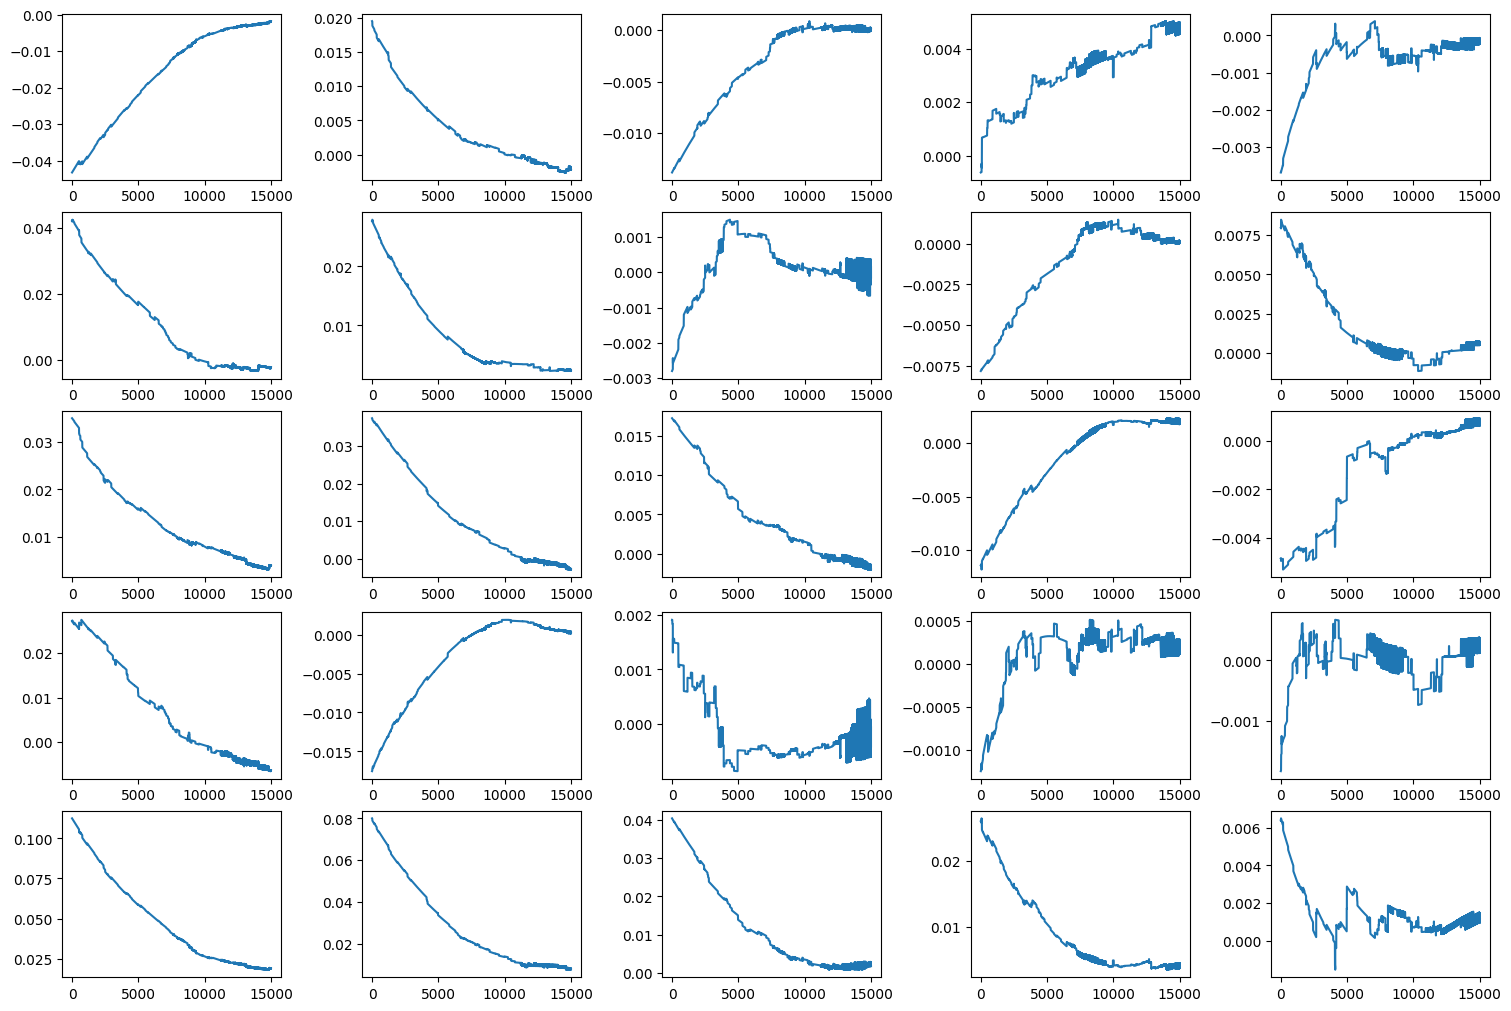

In [ ]:
plt.figure(figsize = (15,10), layout='constrained')
for k in range(25):
  plt.subplot(5,5,k+1)
  plt.plot(gradient_history[:,k])
plt.show()

Now with simple gradient descent, without all of the oscillation preventing techinques built into Adam. Using the default SGD learning rate = 0.01 (note: Adam's default is 0.001, but Adam uses momentum and the 2nd moment to speed that up wherever possible).

Epoch  1500: loss: 0.6837  
Epoch  3000: loss: 0.6659  
Epoch  4500: loss: 0.6271  
Epoch  6000: loss: 0.5421  
Epoch  7500: loss: 0.3773  
Epoch  9000: loss: 0.2015  
Epoch 10500: loss: 0.1314  
Epoch 12000: loss: 0.0998  
Epoch 13500: loss: 0.0810  
Epoch 15000: loss: 0.0684  
gradient_history: (15000, 91)
Total training time: 82.73 secs


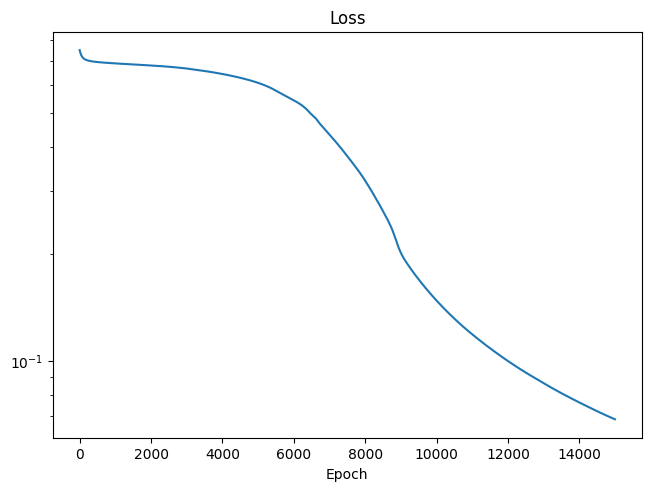

In [ ]:
start = tf.timestamp()
model = binary_classification_model('he_normal')
loggingOptimizer = LoggingOptimizerWrapper(tf.keras.optimizers.SGD(learning_rate=0.01))
model.compile(optimizer=loggingOptimizer, loss='binary_crossentropy')
history = model.fit(train_X, train_Y, epochs=15000, batch_size=train_X.shape[0], verbose=0, callbacks=[LessVerboseEpochLogger()])
duration = tf.timestamp() - start
gradient_history = loggingOptimizer._gradients_by_step.numpy()
print(f"gradient_history: {gradient_history.shape}")
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)

In [ ]:
gradient_events_smooth = sign_change_magnitudes_events(gradient_history, filtering='smooth')
gradient_events_discrete = sign_change_magnitudes_events(gradient_history, filtering='distinct')
print(f"gradient_events: {gradient_events_smooth.shape}")

gradient_events: (15000, 91)


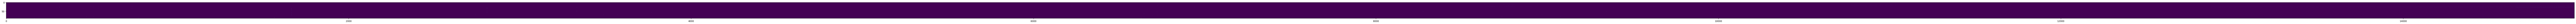

In [ ]:
plt.figure(figsize = (200,500))
plt.imshow(np.abs(gradient_events_discrete.T))
plt.show()

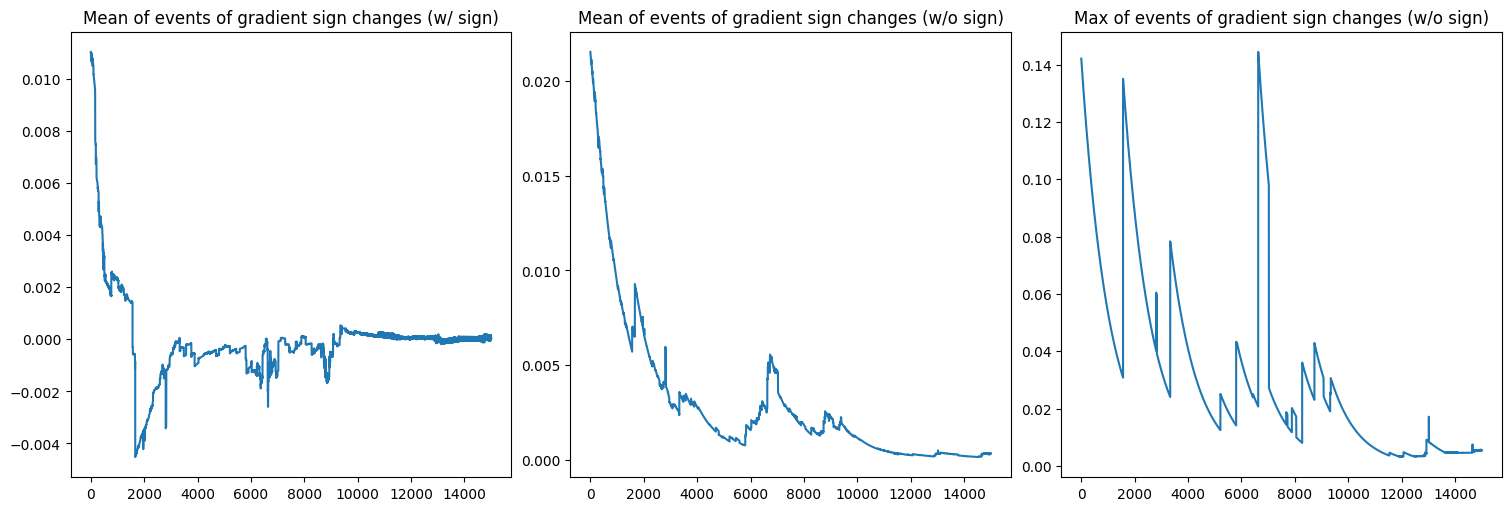

In [ ]:
plt.figure(figsize = (15,5), layout='constrained')
plt.subplot(1,3,1)
plt.plot(np.mean(gradient_events_smooth, axis=1))
plt.title('Mean of events of gradient sign changes (w/ sign)')
plt.subplot(1,3,2)
plt.plot(np.mean(np.abs(gradient_events_smooth), axis=1))
plt.title('Mean of events of gradient sign changes (w/o sign)')
plt.subplot(1,3,3)
plt.plot(np.max(np.abs(gradient_events_smooth), axis=1))
plt.title('Max of events of gradient sign changes (w/o sign)')
plt.show()

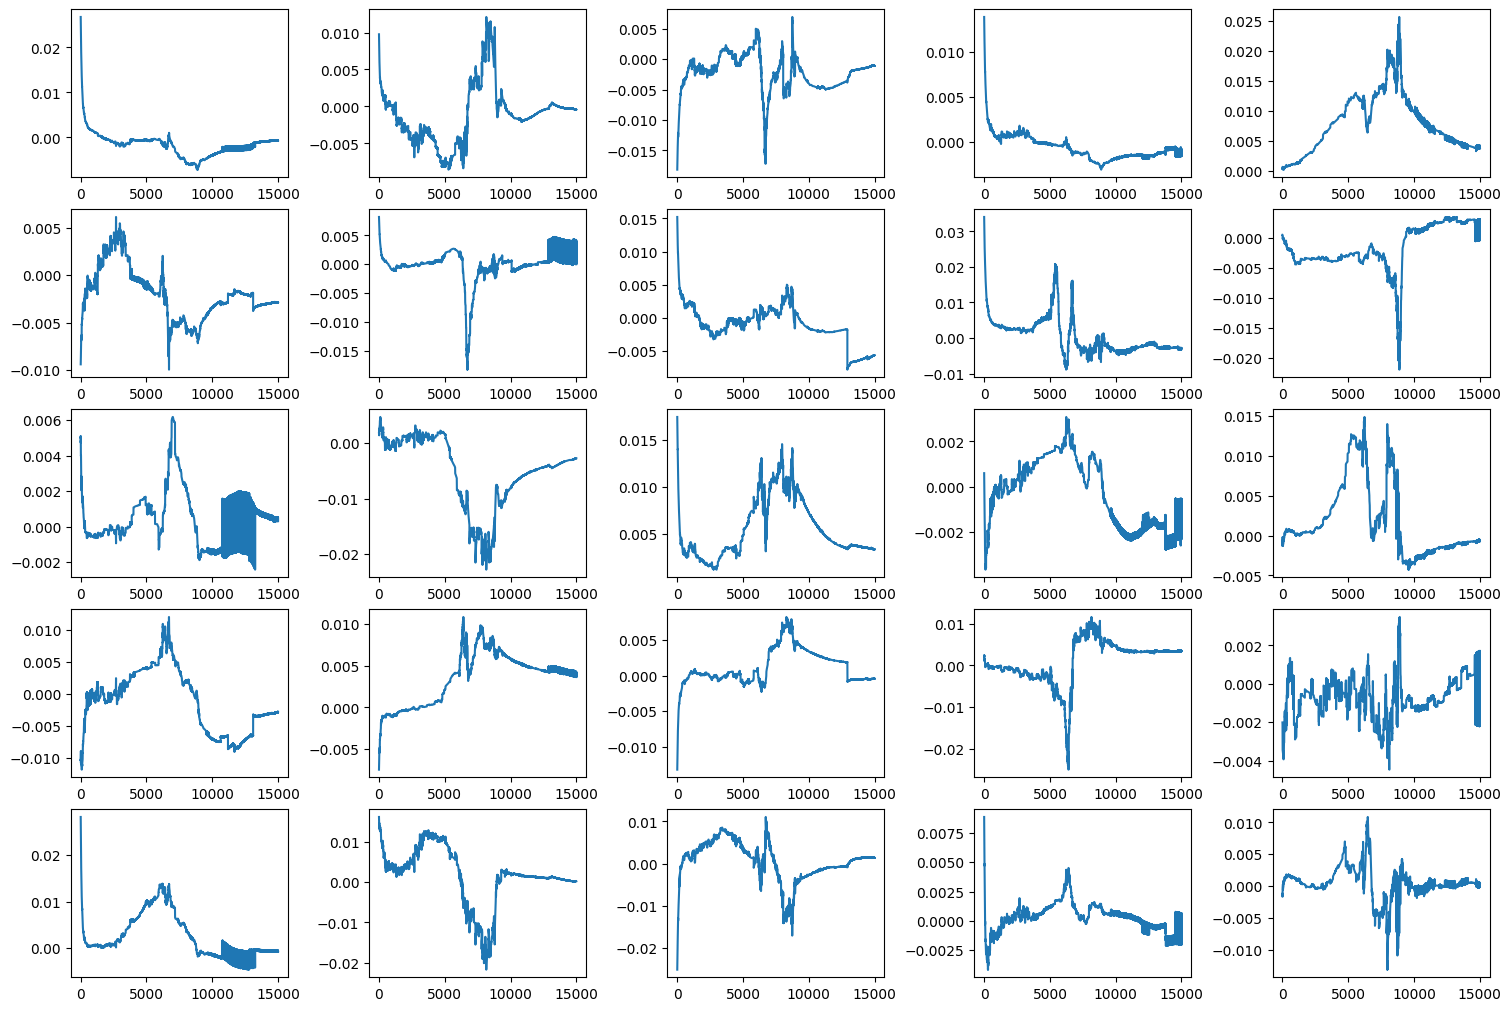

In [ ]:
plt.figure(figsize = (15,10), layout='constrained')
for k in range(25):
  plt.subplot(5,5,k+1)
  plt.plot(gradient_history[:,k])
plt.show()

## Learnings so Far
It's interesting comparing SGD to Adam.
SGD did worse overall in terms of training the model, but it did that with less oscillations than Adam. This seems to follow the adage that trying to avoid over-shooting leads to too-slow movement, and that it's instead better to accept a little bit of oscillation, to find the target quickly while overshooting and then to backtrace.

This fits too with the observation that the gradients are always oscillating a little, even if those oscillations don't move it to change sign. Something I noticed from the earliest gradient plots.

In summary, oscillations are an inherent component of gradient descent within neural network architectures. Every weight is influenced by ever other weight, so the interactions caused by weight updates are extremely complex. It's almost like tectonic activity - a little bit of movement here causes a pressure build-up in another location followed by a little bit of movement there, this leads to many small movements all over the place, but sometimes they sum up to sudden large-scale movements.



## MNIST
Now let's try the same thing on a different problem domain - the MNIST classification task.

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# pre-process into the correct data range
train_images = train_images[0:5000, :] / 255.0
train_labels = train_labels[0:5000]
print(f"train_images shape: {train_images.shape}")
print(f"train_labels shape: {train_labels.shape}")

train_images shape: (5000, 28, 28)
train_labels shape: (5000,)


In [ ]:
def mnist_classification_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10)
  ])
  return model

Epoch 1/10
157/157 [==============================] - 3s 16ms/step - loss: 1.4658
Epoch 2/10
157/157 [==============================] - 11s 70ms/step - loss: 0.9192
Epoch 3/10
157/157 [==============================] - 17s 107ms/step - loss: 0.7745
Epoch 4/10
157/157 [==============================] - 25s 160ms/step - loss: 0.7023
Epoch 5/10
157/157 [==============================] - 32s 201ms/step - loss: 0.6547
Epoch 6/10
157/157 [==============================] - 38s 240ms/step - loss: 0.6209
Epoch 7/10
157/157 [==============================] - 45s 288ms/step - loss: 0.5907
Epoch 8/10
157/157 [==============================] - 58s 370ms/step - loss: 0.5693
Epoch 9/10
157/157 [==============================] - 63s 401ms/step - loss: 0.5491
Epoch 10/10
157/157 [==============================] - 80s 510ms/step - loss: 0.5357
gradient_history: (1570, 101770)
Total training time: 382.44 secs


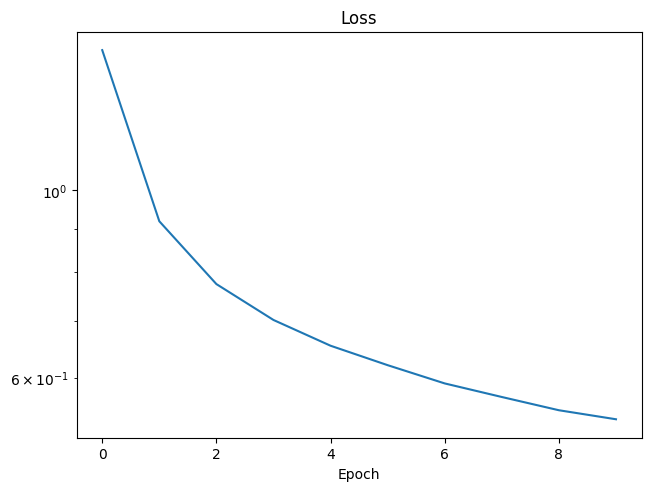

In [ ]:
start = tf.timestamp()
model = mnist_classification_model()
loggingOptimizer = LoggingOptimizerWrapper(tf.keras.optimizers.SGD(learning_rate=0.01))
model.compile(optimizer=loggingOptimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
history = model.fit(train_images, train_labels, epochs=10)
duration = tf.timestamp() - start
gradient_history = loggingOptimizer._gradients_by_step.numpy()
print(f"gradient_history: {gradient_history.shape}")
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)

In [ ]:
gradient_events_smooth = sign_change_magnitudes_events(gradient_history, filtering='smooth')
gradient_events_discrete = sign_change_magnitudes_events(gradient_history, filtering='distinct')
print(f"gradient_events: {gradient_events_smooth.shape}")

gradient_events: (1570, 101770)


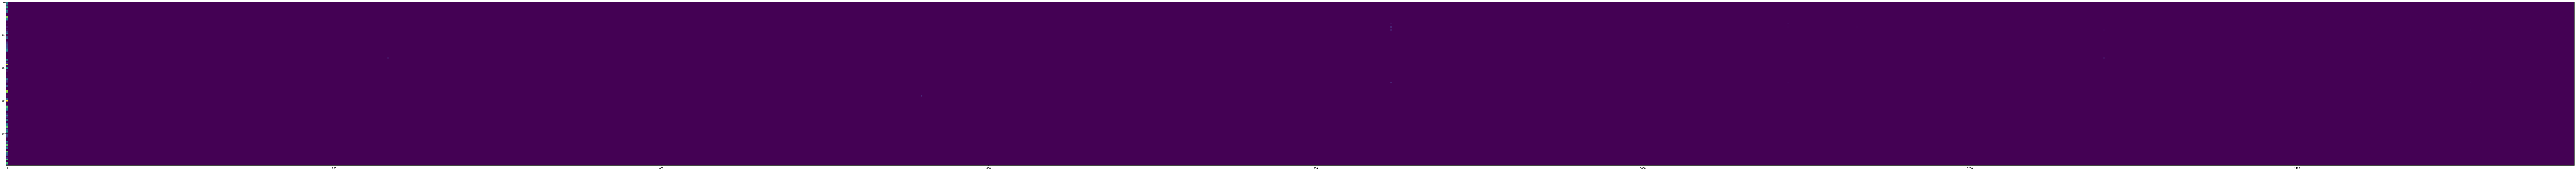

In [ ]:
plt.figure(figsize = (200,500))
plt.imshow(np.abs(gradient_events_discrete[:,0:100].T))
plt.show()

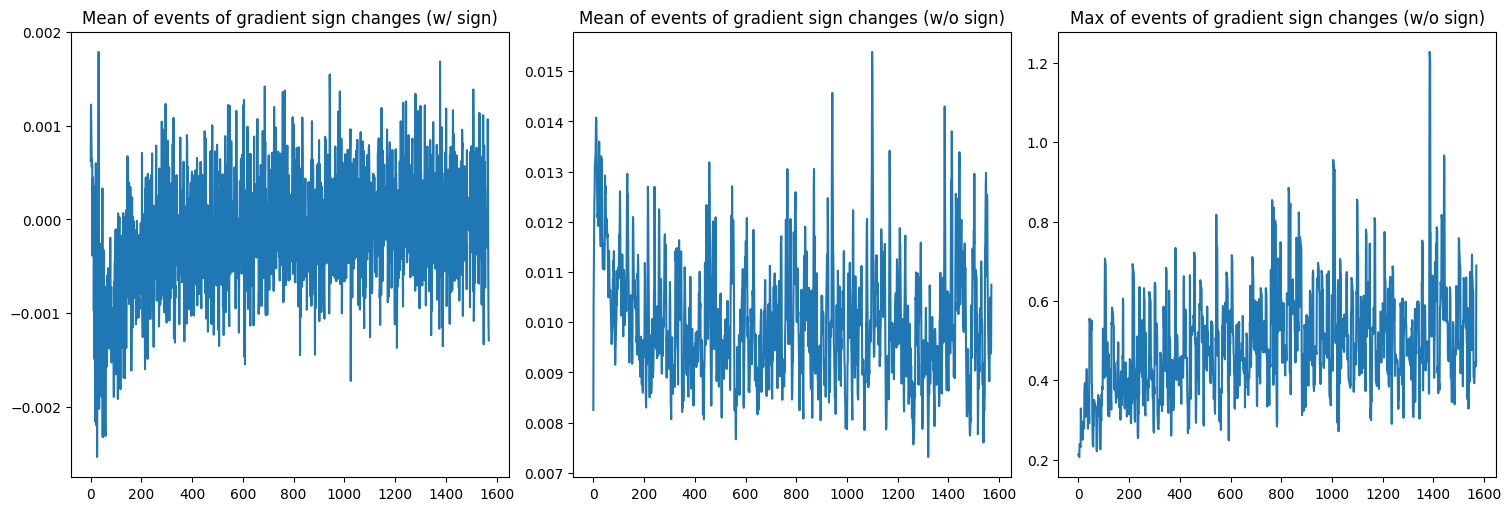

In [ ]:
plt.figure(figsize = (15,5), layout='constrained')
plt.subplot(1,3,1)
plt.plot(np.mean(gradient_events_smooth, axis=1))
plt.title('Mean of events of gradient sign changes (w/ sign)')
plt.subplot(1,3,2)
plt.plot(np.mean(np.abs(gradient_events_smooth), axis=1))
plt.title('Mean of events of gradient sign changes (w/o sign)')
plt.subplot(1,3,3)
plt.plot(np.max(np.abs(gradient_events_smooth), axis=1))
plt.title('Max of events of gradient sign changes (w/o sign)')
plt.show()

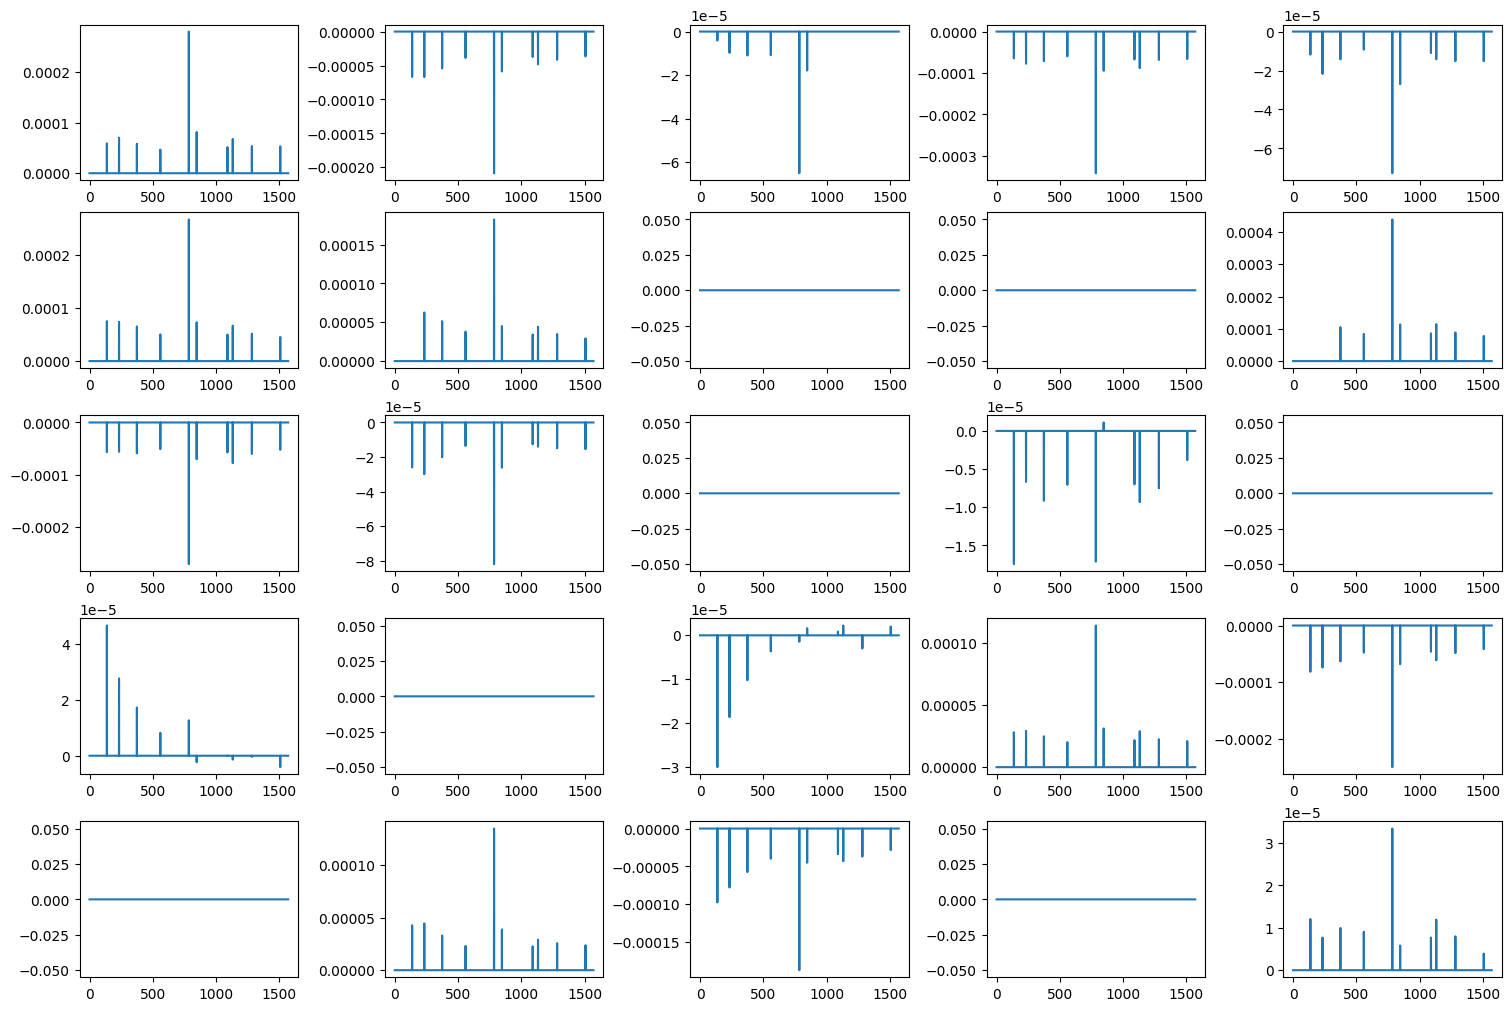

In [ ]:
plt.figure(figsize = (15,10), layout='constrained')
for k in range(25):
  plt.subplot(5,5,k+1)
  plt.plot(gradient_history[:,k])
plt.show()

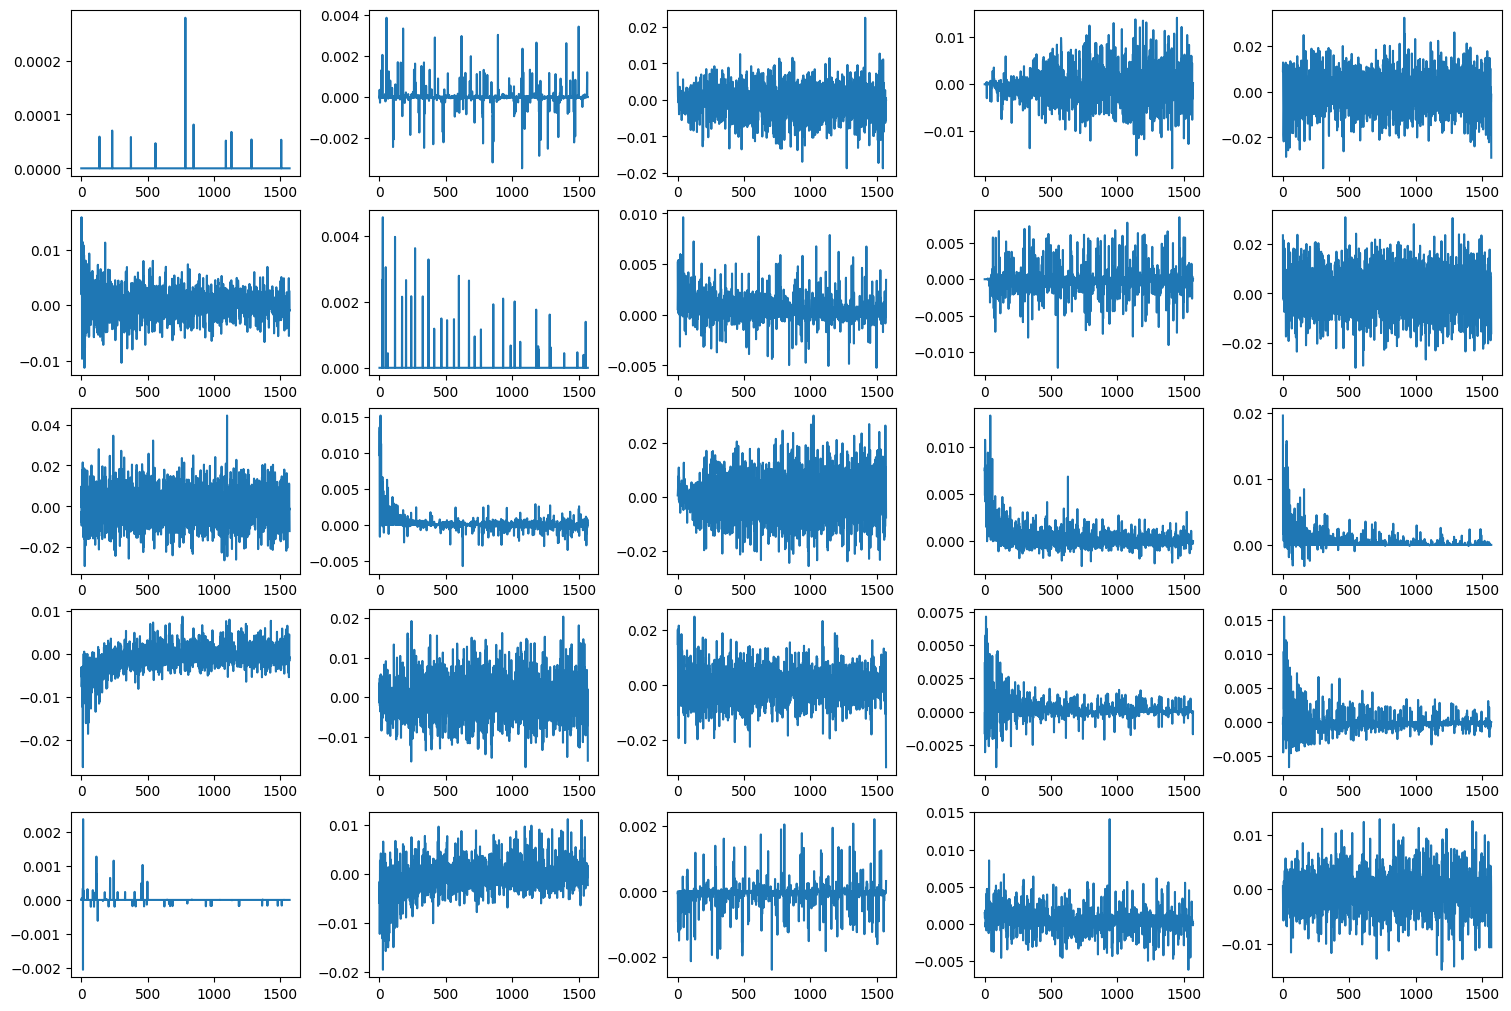

In [ ]:
plt.figure(figsize = (15,10), layout='constrained')
for k in range(25):
  plt.subplot(5,5,k+1)
  plt.plot(gradient_history[:,math.floor(k * (gradient_history.shape[1]/25.))])
plt.show()

Notice that some weights are inactive most of the time (gradients == 0). We can identify this clearly using the visualisation technique I developed in _Learning_visualisations_v2_.

## Performance of Gradient capture and calculations
Notice that the training times-per-epoch got longer and longer. That's most likely due to the poor memory allocation approach in the gradient logger. While there's only a total of 1570 update steps, there's now many more parameters in this model so it's memory footprint is far larger.

It needs to allocate memory upfront, instead of appending each row each update step. I'm also going to need to look at performing stats on the gradients during training, in order to compress the data storage.

Furthermore, the sign-change calculations take a huge amount of time - about 7mins for a single call to `sign_change_magnitudes_events()`. This is untenable. So I'll have to focus on optimising my algorithms before I can do much more with them.

## Next Steps
Look into TensorBoard to check that I'm not doing something that's already available before I continue. And also to get further ideas about how to best capture the gradients and other information.

## Optimised Implementation
After a quick check, it doesn't look like TensorFlow has the capabilities that this does. So let's finish this piece of effort off and turn it into something production ready :)

Here's the plan:
* Combine the capturing abilities of an Optimizer wrapper with a Callback. While it's a little less user-friendly than I'd like, it gives the option for a much easier implementation because the majority of logic sits outside of a `@tf.function` function.
* Split up results per layer.
* Capturing plugin: `GradientCapturingOptimizerWrapper`
  * Captures gradients (per layer), with sampling across weights if many weights. But stores into short cache as needed.
  * Also captures activations (per layer) as % of units in layer.
  * Saves results directly onto a property of the model - in order to make the wiring up simpler.
  * Philosphical rule: does the smallest amount possible that I cannot do in the callback.
* Controlling and aggregating plugin: `GradientStatsCallback`

Initially work on displaying within tensorflow. Later look at adding a visualisation plugin for TensorBoard.


## Sanity Checks
First, some sanity checks to confirm that I can actually do want I want.

In [ ]:
# Check that I can share a property between two plugins
class PropertySharingOptimizerWrapper(tf.keras.optimizers.Optimizer):
  def __init__(self, optimizer='adam', name="PropertySharingOptimizerWrapper", **kwargs):
    """
    Args:
      delegate: real optimizer to wrap. String (name of optimizer) or optimizer instance. See `tf.keras.optimizers`.
    """
    if isinstance(optimizer, str):
      optimizer = tf.keras.optimizers.get(optimizer)
    super(PropertySharingOptimizerWrapper, self).__init__(f"{name}:{optimizer.name}", **kwargs)
    self._delegate = optimizer
    self._count = tf.Variable(0)

  @property
  def count(self):
    return self._count

  def apply_gradients(self, grads_and_vars, name=None, experimental_aggregate_gradients=True):
    self._count.assign_add(1)
    #tf.print(f"apply_gradients: count = {self._count}")
    return self._delegate.apply_gradients(grads_and_vars, name, experimental_aggregate_gradients)

  # delegate all other methods and properties

  def build(self, var_list):
    # Note: this method is usually not called from the outside, so it's not an option for collecting information
    super().build(var_list)

  def _create_slots(self, var_list):
    self._delegate._create_slots(var_list)

  def _create_hypers(self):
    self._delegate._create_hypers()

  def _prepare_local(self, var_device, var_dtype, apply_state):
    return self._delegate._prepare_local(var_device, var_dtype, apply_state)

  def _resource_apply_dense(self, grad, var, apply_state=None):
    return self._delegate._resource_apply_dense(grad, var, apply_state)

  def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
    return self._delegate._resource_apply_sparse(grad, var, indices, apply_state)

  def get_config(self):
    base_config = super(LoggingOptimizerWrapper, self).get_config()
    return {**base_config, "_delegate": tf.keras.optimizers.serialize(self._delegate)}

  @classmethod
  def from_config(cls, config, custom_objects=None):
    delegate_config = config.pop('_delegate')
    delegate = tf.keras.optimizers.deserialize(delegate_config, custom_objects=custom_objects)
    return cls(delegate, **config)

  def _serialize_hyperparameter(self, hyperparameter):
    return self._delegate._serialize_hyperparameter(hyperparameter)

  def get_updates(self, loss, params):
    return self._delegate.get_updates(loss, params)

  def get_weights(self):
    return self._delegate.get_weights()

  def set_weights(self, weights):
    self._delegate.set_weights(weights)

  def variables(self):
    return self._delegate.variables()

  def get_slot(self, var, name):
    return self._delegate.get_slot(var, name)

  def get_slot_names(self):
    return self._delegate.get_slot_names()

class PropertySharingCallback(tf.keras.callbacks.Callback):
  def set_params(self, params):
    print(f"set_params: {params}")
    #self.params = params
    super().set_params(params)

  def set_model(self, model):
    print(f"set_model: {model}")
    #self.model = model
    super().set_model(model)

  def _get_optimizer(self):
    return self.model.optimizer

  def on_train_batch_end(self, batch, logs=None):
    optimizer = self._get_optimizer()
    print(f"on_train_batch_end: batch={batch}, shared_value={optimizer.count.numpy()}")


model = binary_classification_model('he_normal')
propertySharingOptimizer = PropertySharingOptimizerWrapper()
model.compile(optimizer=propertySharingOptimizer, loss='binary_crossentropy')
model.fit(train_X, train_Y, epochs=1, batch_size=20, callbacks=[PropertySharingCallback()])

set_model: <keras.src.engine.sequential.Sequential object at 0x7fbbf8923160>
set_params: {'verbose': 1, 'epochs': 1, 'steps': 15}
on_train_batch_end: batch=0, shared_value=1
 1/15 [=>............................] - ETA: 36s - loss: 0.7719on_train_batch_end: batch=1, shared_value=2
on_train_batch_end: batch=2, shared_value=3
on_train_batch_end: batch=3, shared_value=4
on_train_batch_end: batch=4, shared_value=5
on_train_batch_end: batch=5, shared_value=6
on_train_batch_end: batch=6, shared_value=7
on_train_batch_end: batch=7, shared_value=8
 8/15 [===============>..............] - ETA: 0s - loss: 0.7293 on_train_batch_end: batch=8, shared_value=9
on_train_batch_end: batch=9, shared_value=10
on_train_batch_end: batch=10, shared_value=11
on_train_batch_end: batch=11, shared_value=12
on_train_batch_end: batch=12, shared_value=13
on_train_batch_end: batch=13, shared_value=14
on_train_batch_end: batch=14, shared_value=15
15/15 [==============================] - 3s 9ms/step - loss: 0.7142


### Now the formal implementation

In [5]:
class GradientCollectingOptimizerWrapper(tf.keras.optimizers.Optimizer):
  def __init__(self, optimizer='adam', name="GradientCollectingOptimizerWrapper", **kwargs):
    """
    Wraps a real optimizer to collect stats during training.
    Collects gradients and unit activations during each update step, and makes
    them available as properties.

    Usually combined with GradientStatsCallback.

    Args:
      delegate: real optimizer to wrap. String (name of optimizer) or optimizer instance. See `tf.keras.optimizers`.
    """
    if isinstance(optimizer, str):
      optimizer = tf.keras.optimizers.get(optimizer)
    super(GradientCollectingOptimizerWrapper, self).__init__(f"{name}:{optimizer.name}", **kwargs)
    self._delegate = optimizer
    self._gradients_by_var_ref = None

  @property
  def gradients(self):
    return self._gradients_by_var_ref

  def apply_gradients(self, grads_and_vars, name=None, experimental_aggregate_gradients=True):
    grads_and_vars = list(grads_and_vars)
    if len(grads_and_vars) == 0:
      # It is possible that the grad is empty. In this case,
      # `apply_gradients` is a no-op.
      return self._iterations
    self._collect_gradients(grads_and_vars)
    return self._delegate.apply_gradients(grads_and_vars, name, experimental_aggregate_gradients)

  def _collect_gradients(self, grads_and_vars):
    """
    Does the collection of gradients.
    Collects all gradients without any filtering or data compression,
    but that's ok because this class only holds one set of gradients per update step.
    """
    _, trainable_variables = zip(*grads_and_vars)

    # init on first call
    with tf.init_scope(): # force into eager mode
      self._init_collectors(trainable_variables)

    # collect
    for grad, var in grads_and_vars:
       self._gradients_by_var_ref[var.ref()].assign(grad)

  def _init_collectors(self, var_list):
    if self._gradients_by_var_ref is None:
      self._gradients_by_var_ref = {var.ref(): tf.Variable(tf.zeros_like(var)) for var in var_list}

  # delegate all other methods and properties

  def build(self, var_list):
    # Note: this method is usually not called from the outside, so it's not an option for collecting information
    super().build(var_list)

  def _create_slots(self, var_list):
    self._delegate._create_slots(var_list)

  def _create_hypers(self):
    self._delegate._create_hypers()

  def _prepare_local(self, var_device, var_dtype, apply_state):
    return self._delegate._prepare_local(var_device, var_dtype, apply_state)

  def _resource_apply_dense(self, grad, var, apply_state=None):
    return self._delegate._resource_apply_dense(grad, var, apply_state)

  def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
    return self._delegate._resource_apply_sparse(grad, var, indices, apply_state)

  def get_config(self):
    base_config = super(GradientCollectingOptimizerWrapper, self).get_config()
    return {**base_config, "_delegate": tf.keras.optimizers.serialize(self._delegate)}

  @classmethod
  def from_config(cls, config, custom_objects=None):
    delegate_config = config.pop('_delegate')
    delegate = tf.keras.optimizers.deserialize(delegate_config, custom_objects=custom_objects)
    return cls(delegate, **config)

  def _serialize_hyperparameter(self, hyperparameter):
    return self._delegate._serialize_hyperparameter(hyperparameter)

  def get_updates(self, loss, params):
    return self._delegate.get_updates(loss, params)

  def get_weights(self):
    return self._delegate.get_weights()

  def set_weights(self, weights):
    self._delegate.set_weights(weights)

  def variables(self):
    return self._delegate.variables()

  def get_slot(self, var, name):
    return self._delegate.get_slot(var, name)

  def get_slot_names(self):
    return self._delegate.get_slot_names()

model = binary_classification_model('he_normal')
model.compile(optimizer=GradientCollectingOptimizerWrapper(), loss='binary_crossentropy')

In [56]:
class GradientStatsCallback(tf.keras.callbacks.Callback):
  def __init__(self, **kwargs):
    """
    Aggregates statistics and raw data from training, as obtained by a GradientCollectingOptimizerWrapper.

    To handle large models, collects stats over all gradients, but provides details for only a sampling
    over those gradients. For repeatability, uses a simple proportioned striding across the gradients to sample,
    according to `max_per_layer`.

    Keyword args:
      max_per_layer:
        Maximum number of gradients to track individually, per layer. Default: 10.
      beta:
        Smoothing factor used to in exponential weighted averaging smoothing of sign-change events. Default: derived from window_size
      window_size:
        If not otherwise specified, the smoothing factor beta will be derived to approximate this window size. Default: derived from window_size_factor
      window_size_factor:
        If not otherwise specified, the smoothing window-size will be defined by this as a factor of the total
        number of training steps. Default: 0.05 (1/20th)
      collector:
        Instance of GradientCollectingOptimizerWrapper. Default: attempts to obtain from model.
        Custom implementations just need to provide a `gradients` property.

    Tip: base Callback class holds the following properties:
      self.params = <dict>, eg: {'verbose': 1, 'epochs': 1, 'steps': 15}
      self.model = <tf.keras.Model>
    """
    # defaulting
    self._window_size_factor = kwargs.get('window_size_factor', 1/20.0)
    self._window_size = kwargs.get('window_size', None)
    self._beta = kwargs.get('beta', None)

    # config
    self._collector = kwargs.get('collector', None)
    self._max_per_layer = kwargs.get('max_per_layer', 10)
    self._expected_iterations = None # will be derived later

    # intermediate data storage
    self._initialized = False
    self._iteration = 0
    self._var_refs = None
    self._track_indices_by_layer = {} # dict[var.ref() -> np.array(int)]
    self._sign_accumulators_by_layer = {} # dict[var.ref -> dict[prop_name -> data]]

    # collected data - individual values
    # (current plan is to store in full resolution along time axis, and only reduce on output)
    self._gradients_by_layer_by_step = {}  # dict[var.ref() -> list] (later converted to dict[var.ref() -> np.array(n,fs)] )
    self._activations_by_layer_by_step = {}  # dict[var.ref() -> list] (later converted to dict[var.ref() -> np.array(n,fs)] )
    self._sign_distinct_events_by_layer_by_step = {}  # dict[var.ref -> list] (later converted to dict[var.ref() -> np.array(n,fs)] )
    self._sign_smooth_events_by_layer_by_step = {}  # dict[var.ref -> list] (later converted to dict[var.ref() -> np.array(n,fs)] )

    # collected data - stats
    # (current plan is to store in full resolution along time axis, and only reduce on output)
    self._sign_stats_by_layer_by_step = {} # currently only the mean

  @property
  def keys(self):
    """
    Returns the keys used to index into the dictionaries returned by most of these properties.
    """
    return self._var_refs

  @property
  def gradients(self):
    """
    Returns the sampled gradients for all variable items that have been individually tracked.
    This will usually be a sub-set of all gradients in the model.

    Dict[variable.ref() -> List[Tensor(float, shape=(None,))]]
    """
    return self._gradients_by_layer_by_step

  @property
  def activations(self):
    """
    Dict[variable.ref() -> List[np.array(Bool, shape=(None,))]]
    """
    return self._activations_by_layer_by_step

  # TODO: turn into a method with a number of options:
  #    smoothing: distinct vs smooth.
  #    block_size: Default 1.
  #    reduction_op:
  #      NOT YET IMPLEMENTED
  #      Controls how data is reduced along the time axis in order to reduce memory usage.
  #      Default: 'mean'
  @property
  def sign_changes(self):
    """
    Gets the distinct sign change events for all variable items that have been individually tracked.
    Dict[variable.ref() -> List[Tensor(float, shape=(None,))]]
    """
    return self._sign_distinct_events_by_layer_by_step

  @property
  def sign_changes_smooth(self):
    """
    Dict[variable.ref() -> List[Tensor(float, shape=(None,))]]
    """
    return self._sign_smooth_events_by_layer_by_step

  @property
  def sign_stats(self):
    """
    In the long term, this is likely to include min, max, mean, 10th-percentile, 90th-pencentile,
    to represent stats over more features than are returned as individual values,
    and to represent stats over blocks in time.
    It will also need to be correlated with something to identify the update iteration and/or epoch indices for plotting on the x-axis.
    This will likely be a pattern that I'll follow for other data, such as the gradients themselves, and later for the loss.
    --> Actually, for this I don't think I will reduce along the time axis (only for the raw gradients/sign_changes to make generation of images easier).
    """
    return self._sign_stats_by_layer_by_step

  def _init(self, var_ref_list):
    if self._initialized:
      return

    self._var_refs = var_ref_list

    # derive beta from expected number of training iterations
    self._expected_iterations = self.params['epochs'] * self.params['steps']
    if self._beta is None:
      if self._window_size is None:
        self._window_size = 2 ** math.floor(math.log2(self._expected_iterations * self._window_size_factor))
      self._beta = 1 - 1/self._window_size

    print(f"its: {self._expected_iterations}, window_size: {self._window_size}, beta: {self._beta}")

    # decide which variable indices to record in detail
    self._track_indices_by_layer
    for var_ref in var_ref_list:
      var = var_ref.deref()
      #print(f"var: {var.name}, shape={var.shape}, total={tf.size(var)}")
      sz = tf.size(var)
      if sz < self._max_per_layer:
        self._track_indices_by_layer[var_ref] = np.arange(sz)
      else:
        indices = np.round(np.linspace(0,sz-1, self._max_per_layer)).astype(int)
        self._track_indices_by_layer[var_ref] = indices

    # setup empty structures for recording raw data
    self._gradients_by_layer_by_step = {var_ref: [] for var_ref in var_ref_list}
    self._activations_by_layer_by_step = {var_ref: [] for var_ref in var_ref_list}
    self._sign_distinct_events_by_layer_by_step = {var_ref: [] for var_ref in var_ref_list}
    self._sign_smooth_events_by_layer_by_step = {var_ref: [] for var_ref in var_ref_list}
    self._sign_stats_by_layer_by_step = {var_ref: [] for var_ref in var_ref_list}

    self._sign_stats_real = {var_ref: [] for var_ref in var_ref_list}

    # setup empty structures for interim data processing
    self._sign_accumulators_by_layer = {var_ref: {} for var_ref in var_ref_list}
    self._initialized = True

  def _accum_individual_gradients(self, iteration, var_ref, all_grads, selected_grads, selection):
    self._gradients_by_layer_by_step[var_ref].append(selected_grads)

    # approximation of whether each unit is active -- may not be a very good
    # estimation though
    self._activations_by_layer_by_step[var_ref].append(selected_grads != 0)

  def _accum_gradient_sign_change_stats(self, iteration, var_ref, all_grads, selected_grads, selection):
    # run accumulators against all gradients (will re-apply filtering later)
    grads = all_grads

    # all "accum{...}" are interpreted as tracking up-to-but-excluding the current gradient
    # (also note that due to the way that we manipulate these, a single instance is
    #  used throughout as a variable that changes over time)
    # ..0 = current block
    # ..1 = previous block
    accum = self._sign_accumulators_by_layer[var_ref]
    events = self._sign_distinct_events_by_layer_by_step[var_ref]
    smooth_events = self._sign_smooth_events_by_layer_by_step[var_ref]
    sign_stats = self._sign_stats_by_layer_by_step[var_ref]
    if not 'sign0' in accum:
      accum['sign0'] = np.zeros_like(grads)
      accum['peak0'] = np.zeros_like(grads)
      accum['peak_point0'] = np.zeros_like(grads, dtype=int)
      accum['change_point0'] = np.zeros_like(grads, dtype=int)
      accum['peak1'] = np.zeros_like(grads)
    sign0 = accum['sign0']
    peak0 = accum['peak0']
    peak_point0 = accum['peak_point0']
    change_point0 = accum['change_point0']
    peak1 = accum['peak1']
    fs = grads.shape[0] # number of input features

    # identify sign flips
    sign = sign_reduce([sign0, np.sign(grads)], axis=0)  # sorts out the zeros, so almost always only +1 or -1
    flips = (sign0 * sign) < 0                           # only flips once x becomes +1 or -1, not when it just touches 0
    assert sign.shape == (fs,), sign.shape
    assert flips.shape == (fs,), flips.shape
    assert np.all(np.sign(grads)[flips] != 0)

    # rotate blocks on sign flips
    peak1[flips] = peak0[flips]

    # start new block on sign flips
    assert sign0.shape == (fs,), sign0.shape
    assert sign.shape == (fs,), sign.shape
    assert sign0[flips].shape == sign[flips].shape, sign0[flips].shape
    sign0[flips] = sign[flips]
    peak0[flips] = 0.0
    change_point0[flips] = iteration

    # accumulate against current block
    sign0[:] = sign[:]
    peak0[sign >= 0] = np.max([peak0, grads], axis=0)[sign >= 0]
    peak0[sign < 0]  = np.min([peak0, grads], axis=0)[sign < 0]
    assert sign0.shape == (fs,), sign0.shape
    assert peak0.shape == (fs,), peak0.shape

    # extend length of raw data
    events.append(np.zeros_like(grads))  # zero everywhere else
    sign_stats.append(0.0)
    self._sign_stats_real[var_ref].append(0.0)
    assert events[-1].shape == (fs,), events[-1].shape

    # track magnitudes but store against change points
    # (TODO this is probably slow and could be optimised. Maybe:
    #   store events etc. as a tensor from the start, instead of a list,
    #   with pre-allocation. Then use tf.tensor_scatter_nd_update(events, ..indices.., mag)
    #)
    mag = peak0 - peak1 # signed magnitude of change
    for j, i2 in enumerate(change_point0):
      assert np.shape(events[i2][j]) == (), np.shape(events[i2][j])
      assert np.shape(mag[j]) == (), np.shape(mag[j])
      before = events[i2][j]
      events[i2][j] = mag[j]
      # also track sign_stats of the abs(mags), emulating what we'd get if we summed across the whole
      # timeline after all the events were settled upon
      sign_stats[i2] += np.abs(mag[j] - before)  # add diff of abs values
      #sign_stats[i2] += (np.abs(mag[j]) - np.abs(before))  # add diff of abs values
      self._sign_stats_real[var_ref][i2] += mag[j] - before

    # TODO compute stats across this data
    # And then apply selection filter
    # Idea:
    #   The accumulation for stats like mean is just a linear sum along the features axis, repeated along the time axis.
    #   However, each individual feature is itself just a series of discrete blips that have been either smoothed or not along the time axis.
    #   Thus I should be able to maintain a 1D tensor along the time axis, and just do a simple mathematical "add" operation each time there's a blip
    #   And then apply the same smoothing rule afterwards.

  # TODO collect gradient stats (ie: percentiles)
  # TODO compress along training length
  def on_train_batch_end(self, batch, logs=None):
    """
    Fetches the data from the collector and stores it.
    Performs all the pre-processing needed in order to reduce total memory usage.
    """
    gradients = self._get_collector().gradients
    self._init(gradients.keys())
    for var_ref, grads in gradients.items():
      flat_grads = tf.reshape(grads, [-1])
      indices = self._track_indices_by_layer[var_ref]
      selected_grads = tf.gather(flat_grads, indices)
      self._accum_individual_gradients(self._iteration, var_ref, flat_grads, selected_grads, indices)
      self._accum_gradient_sign_change_stats(self._iteration, var_ref, flat_grads, selected_grads, indices)
    self._iteration += 1

  def on_train_end(self, logs=None):
    """
    Cleans up the data before making it available for external callers.
    Converts the lists of arrays to matrices.

    Remember that we are working against the filtered and compressed data set now.
    """
    for var_ref, grads in self._gradients_by_layer_by_step.items():
      self._gradients_by_layer_by_step[var_ref] = np.stack(grads, axis=0)
      #print(f"{var_ref.deref().name}: gradients stacked: {self._gradients_by_layer_by_step[var_ref].shape}")

    for var_ref, activations in self._activations_by_layer_by_step.items():
      self._activations_by_layer_by_step[var_ref] = np.stack(activations, axis=0)

    for var_ref, events in self._sign_distinct_events_by_layer_by_step.items():
      self._sign_distinct_events_by_layer_by_step[var_ref] = np.stack(events, axis=0)
      #print(f"{var_ref.deref().name}: events stacked={self._sign_distinct_events_by_layer_by_step[var_ref].shape}")

    self._sign_stats_real_smooth = {}
    for var_ref, stats in self._sign_stats_real.items():
      fs = tf.size(var_ref.deref())
      self._sign_stats_real[var_ref] = np.stack(stats, axis=0) / float(fs)
      accum = stats[0]
      smooth = np.zeros(shape=(len(stats), 1))
      for i, stat in enumerate(stats):
        accum = self._beta*accum + stat # would normally be ... + (1-self._beta)*stat, but we want it to jump straight up
        smooth[i,0] = accum
      self._sign_stats_real_smooth[var_ref] = smooth / float(fs)



    # compute smoothed event stats
    # (also convert from sum to mean)
    for var_ref, stats in self._sign_stats_by_layer_by_step.items():
      fs = tf.size(var_ref.deref())
      accum = stats[0]
      smooth = np.zeros(shape=(len(stats), 1))
      for i, stat in enumerate(stats):
        accum = self._beta*accum + stat # would normally be ... + (1-self._beta)*stat, but we want it to jump straight up
        smooth[i,0] = accum
      self._sign_stats_by_layer_by_step[var_ref] = smooth / float(fs)


    # compute smoothed events
    # (TODO can compute this on demand, as only needed across the selected features)
    # (TODO figure how to handle this if I want to compress along the iterations axis)
    for var_ref, events in self._sign_smooth_events_by_layer_by_step.items():
      distinct = self._sign_distinct_events_by_layer_by_step[var_ref]
      accum = distinct[0,:]
      smooth = np.zeros_like(distinct)
      #print(f"distinct: {distinct.shape}, accum: {accum.shape}, smooth: {smooth.shape}")
      for i, event in enumerate(distinct):  # iterates through rows of matrix
        assert event.shape == accum.shape, event.shape
        accum = self._beta*accum + (1-self._beta)*event
        accum[event != 0] = event[event != 0]  # reset on events
        smooth[i,:] = accum
      self._sign_smooth_events_by_layer_by_step[var_ref] = smooth

    self._sign_stats2 = {}
    for var_ref in self._var_refs:
        self._sign_stats2[var_ref] = np.mean(np.abs(self._sign_smooth_events_by_layer_by_step[var_ref]), axis=1, keepdims=True)

  # TODO update to just look for anything that provides a 'gradients' property.
  def _get_collector(self):
    """
    Looks into the model for the GradientCollectingOptimizerWrapper.
    If not found, raises error.
    """
    if self._collector is not None:
      return self._collector
    opt = self.model.optimizer
    if isinstance(opt, GradientCollectingOptimizerWrapper):
      return opt
    raise RuntimeError("A GradientCollectingOptimizerWrapper is not set on the model. Try setting 'optimizer' kwarg during construction.")

gradientStatsCallback = GradientStatsCallback()
model.fit(train_X, train_Y, epochs=4, batch_size=20, callbacks=[gradientStatsCallback])
print(f"gradients.keys: {len(gradientStatsCallback.gradients)}")
print(f"gradients.len: {len(next(iter(gradientStatsCallback.gradients.values())))}")
print(f"gradients:")
for var_ref in gradientStatsCallback.keys:
  print(f"  {var_ref.deref().name:20}, \
    gradients: {gradientStatsCallback.gradients[var_ref].shape},  \
    activations: {gradientStatsCallback.activations[var_ref].shape}, \
    sign_changes: {gradientStatsCallback.sign_changes[var_ref].shape}|{gradientStatsCallback.sign_changes_smooth[var_ref].shape}), \
    sign_stats: {gradientStatsCallback.sign_stats[var_ref].shape}|{gradientStatsCallback._sign_stats2[var_ref].shape}")

Epoch 1/4
its: 60, window_size: 2, beta: 0.5
 5/15 [=========>....................] - ETA: 0s - loss: 0.6740

15/15 [==============================] - 0s 16ms/step - loss: 0.6671
Epoch 2/4
15/15 [==============================] - 0s 15ms/step - loss: 0.6665
Epoch 3/4
15/15 [==============================] - 0s 24ms/step - loss: 0.6657
Epoch 4/4
15/15 [==============================] - 0s 16ms/step - loss: 0.6649
gradients.keys: 6
gradients.len: 60
gradients:
  dense/kernel:0      ,     gradients: (60, 10),      activations: (60, 10),     sign_changes: (60, 20)|(60, 20)),     sign_stats: (60, 1)|(60, 1)
  dense/bias:0        ,     gradients: (60, 10),      activations: (60, 10),     sign_changes: (60, 10)|(60, 10)),     sign_stats: (60, 1)|(60, 1)
  dense_1/kernel:0    ,     gradients: (60, 10),      activations: (60, 10),     sign_changes: (60, 50)|(60, 50)),     sign_stats: (60, 1)|(60, 1)
  dense_1/bias:0      ,     gradients: (60, 5),      activations: (60, 5),     sign_changes: (60, 5)|(60, 5)),     sign_stats: (60, 1)|(60, 1)
  dense_2/kernel:0    ,     gradients: (60, 5),      activation

In [57]:
vk = next(iter(gradientStatsCallback.gradients.keys()))
gs = gradientStatsCallback.gradients[vk]
acs = gradientStatsCallback.activations[vk]
gs_sign = gradientStatsCallback.sign_changes[vk]
sign_stats = gradientStatsCallback.sign_stats[vk]
print(f"gradients: {gs.shape}, sign_changes: {gs_sign.shape}, sign_stats: {sign_stats.shape}")

gradients: (60, 10), sign_changes: (60, 20), sign_stats: (60, 1)


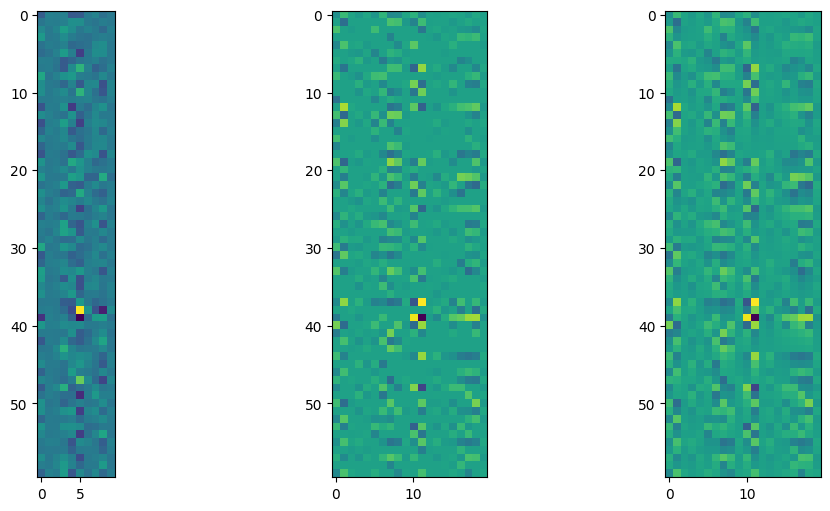

In [58]:
plt.figure(figsize = (10,5), layout='constrained')
plt.subplot(1,3,1)
plt.imshow(gradientStatsCallback.gradients[vk])
plt.subplot(1,3,2)
plt.imshow(gradientStatsCallback.sign_changes[vk])
plt.subplot(1,3,3)
plt.imshow(gradientStatsCallback.sign_changes_smooth[vk])

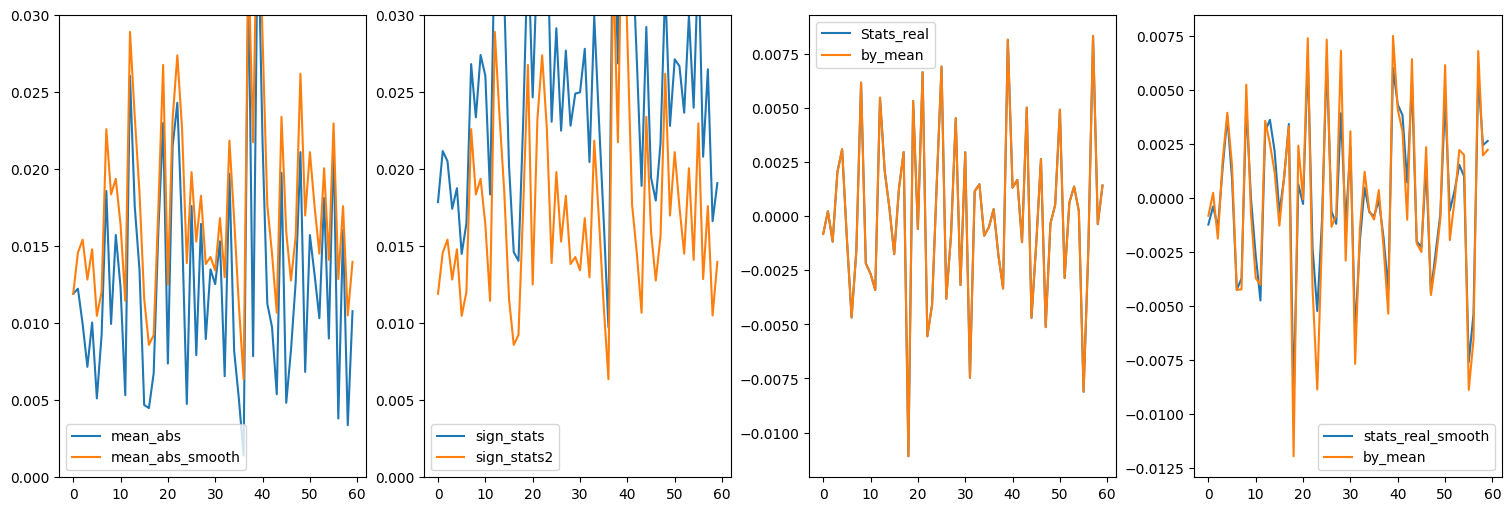

In [59]:
plt.figure(figsize = (15,5), layout='constrained')
plt.subplot(1,4,1)
plt.plot(np.mean(np.abs(gradientStatsCallback.sign_changes[vk]), axis=1), label="mean_abs")
plt.plot(np.mean(np.abs(gradientStatsCallback.sign_changes_smooth[vk]), axis=1), label="mean_abs_smooth")
plt.ylim(0,0.03)
plt.legend()
plt.subplot(1,4,2)
plt.plot(gradientStatsCallback.sign_stats[vk], label="sign_stats")
plt.plot(gradientStatsCallback._sign_stats2[vk], label="sign_stats2")
plt.ylim(0,0.03)
plt.legend()
plt.subplot(1,4,3)
plt.plot(gradientStatsCallback._sign_stats_real[vk], label="Stats_real")
#plt.plot(gradientStatsCallback._sign_stats_real_smooth[vk], label="real_smooth")
plt.plot(np.mean(gradientStatsCallback.sign_changes[vk], axis=1), label="by_mean")
plt.legend()
plt.subplot(1,4,4)
plt.plot(gradientStatsCallback._sign_stats_real_smooth[vk], label="stats_real_smooth")
plt.plot(np.mean(gradientStatsCallback.sign_changes_smooth[vk], axis=1), label="by_mean")
plt.legend()

plt.show()

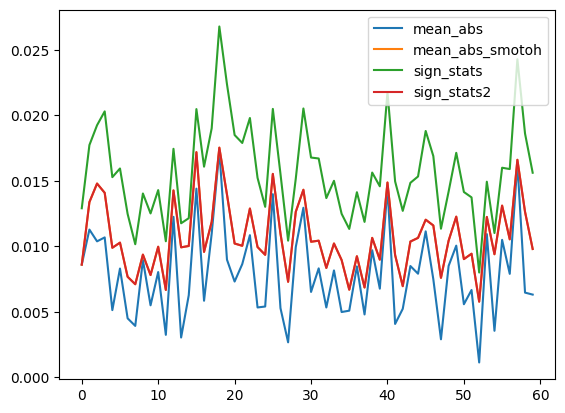

In [27]:
plt.plot(np.mean(np.abs(gradientStatsCallback.sign_changes[vk]), axis=1), label="mean_abs")
plt.plot(np.mean(np.abs(gradientStatsCallback.sign_changes_smooth[vk]), axis=1), label="mean_abs_smotoh")
plt.plot(gradientStatsCallback.sign_stats[vk], label="sign_stats")
plt.plot(gradientStatsCallback._sign_stats2[vk], label="sign_stats2")
plt.legend()

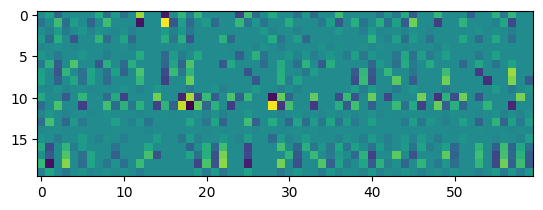

In [20]:
plt.imshow(gradientStatsCallback.sign_changes[vk].T)

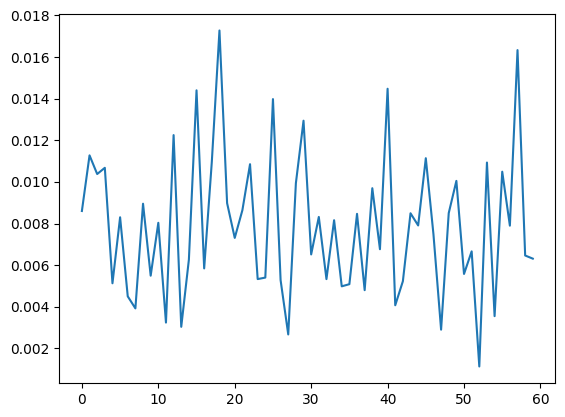

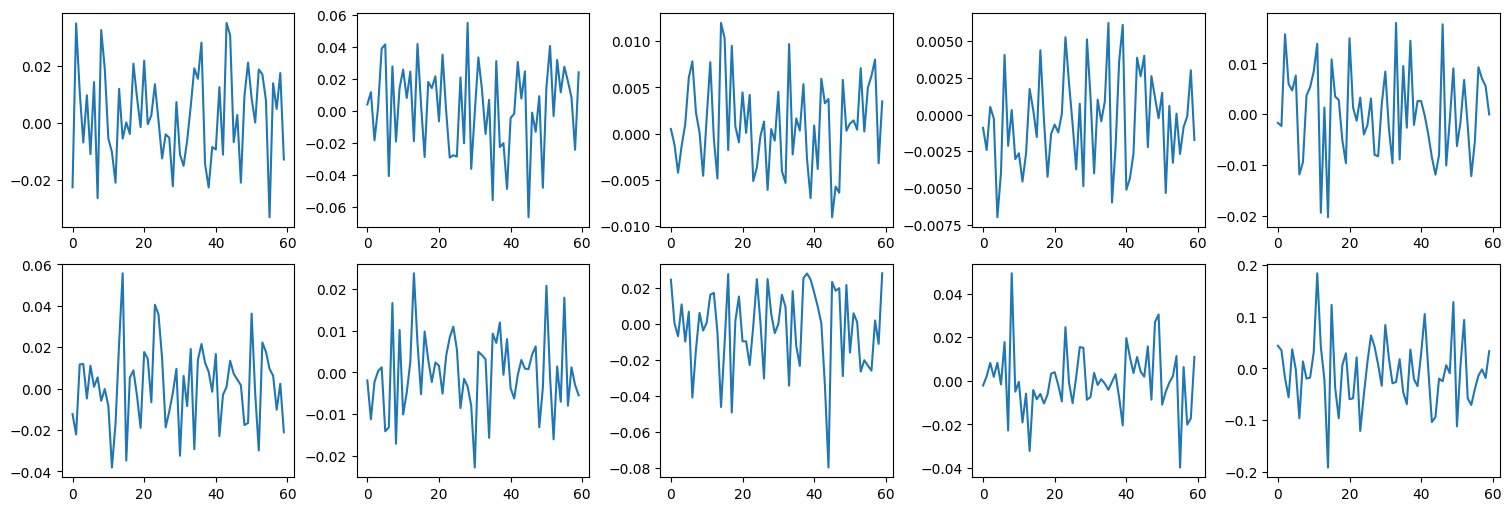

In [42]:
vk = next(iter(gradientStatsCallback.gradients.keys()))
plt.figure(figsize = (15,5), layout='constrained')
for k in range(10):
  plt.subplot(2,5,k+1)
  plt.plot(gradientStatsCallback.gradients[vk][:,k])
plt.show()

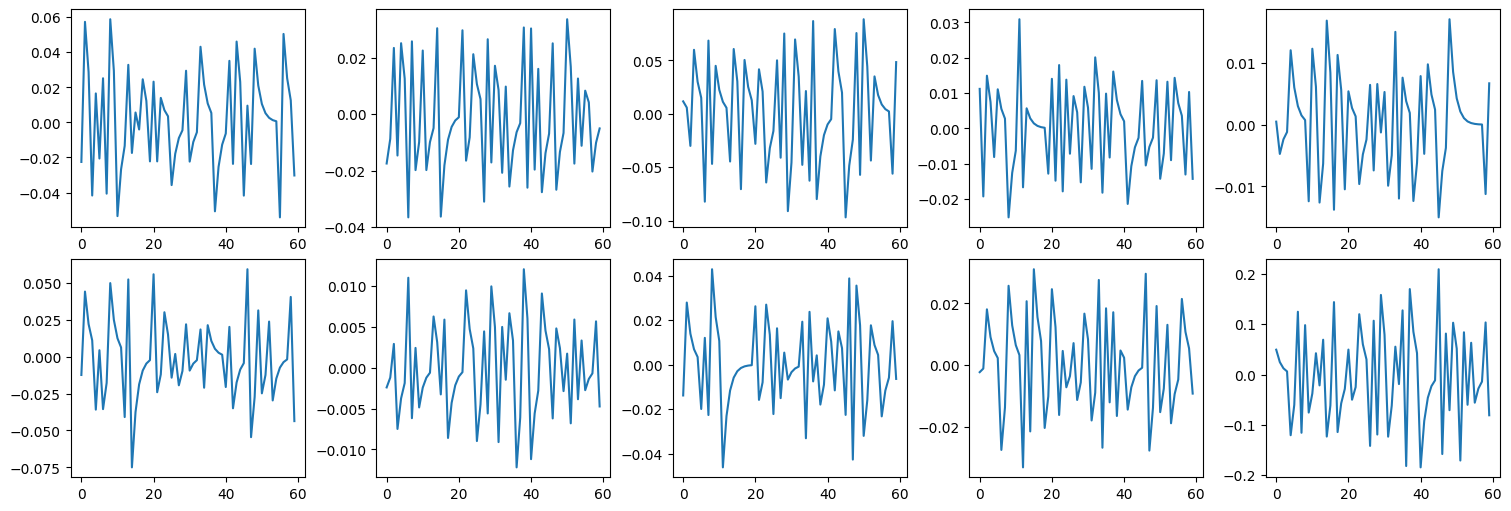

In [43]:
vk = next(iter(gradientStatsCallback.gradients.keys()))
plt.figure(figsize = (15,5), layout='constrained')
for k in range(10):
  plt.subplot(2,5,k+1)
  plt.plot(gradientStatsCallback.sign_changes_smooth[vk][:,k])
plt.show()

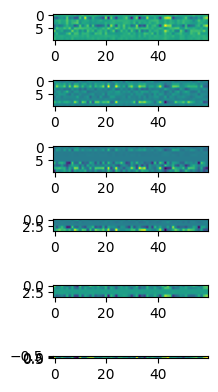

In [ ]:
plt.figure(figsize = (2,5))
for i, grads in enumerate(gradientStatsCallback.gradients.values()):
  plt.subplot(len(gradientStatsCallback.gradients),1,i+1)
  plt.imshow(grads.T)
plt.show()

In [ ]:
gradientStatsCallback.gradient_sign_changes_distinct

{<Reference wrapping <tf.Variable 'dense_42/kernel:0' shape=(2, 10) dtype=float32, numpy=
 array([[-1.7352016 ,  0.04989234,  0.7513793 ,  0.84643817, -0.46773595,
          0.34660327,  0.08474264, -0.89655566,  1.3762    ,  0.6462515 ],
        [-1.3445592 , -1.0101886 ,  0.14390087, -0.3149552 ,  0.06742284,
          0.9028359 , -0.17893718, -0.83123416, -0.01925579, -2.1235845 ]],
       dtype=float32)>>: array([[-0.01568545,  0.00770001, -0.00662948, ..., -0.00096328,
          0.07968549,  0.0034812 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        